**PERFORMANCE ON IMBALANCED DATASETS**

**SOL DEFINITION**

In [ ]:
import tensorflow as tf
import math
pi = tf.constant(math.pi)
acc = lambda TN,FP,FN,TP: tf.math.divide_no_nan(TP+TN,TN+FP+FN+TP)
prec = lambda TN,FP,FN,TP: tf.math.divide_no_nan(TP,FP+TP)
rec = lambda TN,FP,FN,TP: tf.math.divide_no_nan(TP,FN+TP)
spec = lambda TN,FP,FN,TP: tf.math.divide_no_nan(TN,FP+TN)
f1s = lambda TN,FP,FN,TP: 2.*tf.math.divide_no_nan(prec(TN,FP,FN,TP)*\
                          rec(TN,FP,FN,TP),prec(TN,FP,FN,TP)+rec(TN,FP,FN,TP))
tss = lambda TN,FP,FN,TP: rec(TN,FP,FN,TP)+spec(TN,FP,FN,TP)-1.
csi = lambda TN,FP,FN,TP: tf.math.divide_no_nan(TP,FN+FP+TP)
hss1 = lambda TN,FP,FN,TP: tf.math.divide_no_nan(TP-FP,FN+TP)
hss2 = lambda TN,FP,FN,TP: tf.math.divide_no_nan(2.*((TP*TN)-(FP*FN)),((TP+FN)\
                            *(FN+TN))+((TP+FP)*(TN+FP)))
bacc = lambda TN,FP,FN,TP: tf.math.divide_no_nan(rec(TN,FP,FN,TP)+spec(TN,FP,FN,TP),2.0)

F_unif = lambda x: x
F_cos = lambda x,mu,delta: tf.where(x<mu-delta,0.,tf.where(x>mu+delta,1.,\
        0.5*(1.+tf.math.divide(x-mu,delta)+1./pi*tf.math.sin(pi*\
         tf.math.divide(x-mu,delta)))))



def SOL(score = 'accuracy', distribution = 'uniform',\
        mu = 0.5, delta = 0.1, mode = 'average'):

    if score == 'accuracy':
        score = acc
    if score == 'precision':
        score = prec
    if score == 'recall':
        score = rec
    if score == 'specificity':
        score = spec
    if score == 'f1_score':
        score = f1s
    if score == 'tss':
        score = tss
    if score == 'csi':
        score = csi
    if score == 'hss1':
        score = hss1
    if score == 'hss2':
        score = hss2
    if score == 'bacc':
        score = bacc

    if distribution == 'uniform':
        distr = F_unif

    if distribution == 'cosine':
        if type(mu) is not list:
            distr = lambda x: F_cos(x,mu,delta)
        else:
            distr = [lambda x: F_cos(x,mu[j],delta[j]) for j in \
                     range(0,len(mu))]

    def SOL_(y_true, y_pred):

        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        if y_pred.shape[1] == 1:

            TN = tf.reduce_sum((1.-y_true)*(1.-distr(y_pred)))
            TP = tf.reduce_sum(y_true*distr(y_pred))
            FP = tf.reduce_sum((1.-y_true)*distr(y_pred))
            FN = tf.reduce_sum(y_true*(1.-distr(y_pred)))

            return -score(TN,FP,FN,TP) + 1.

        else:

            score_arr = []
            num_c0_arr = []


            for j in range(0,y_pred.shape[1]):

                y_pred_ = y_pred[:,j]
                y_true_ = y_true[:,j]

                if type(mu) is not list:

                    TN = tf.reduce_sum((1.-y_true_)*(1.-distr(y_pred_)))
                    TP = tf.reduce_sum(y_true_*distr(y_pred_))
                    FP = tf.reduce_sum((1.-y_true_)*distr(y_pred_))
                    FN = tf.reduce_sum(y_true_*(1.-distr(y_pred_)))

                else:

                    TN = tf.reduce_sum((1.-y_true_)*(1.-distr[j](y_pred_)))
                    TP = tf.reduce_sum(y_true_*distr[j](y_pred_))
                    FP = tf.reduce_sum((1.-y_true_)*distr[j](y_pred_))
                    FN = tf.reduce_sum(y_true_*(1.-distr[j](y_pred_)))

                score_arr.append(score(TN,FP,FN,TP))

                if mode == 'weighted':
                    num_c0_arr.append(tf.cast(tf.shape(y_true_)[0],\
                                        tf.float32)-tf.reduce_sum(y_true_))

            score_arr = tf.stack(score_arr,axis=0)

            if mode == 'weighted':
                num_c0_arr = tf.stack(num_c0_arr,axis=0)
                final_score = tf.math.divide_no_nan(tf.reduce_sum\
                            (score_arr*num_c0_arr),tf.reduce_sum(num_c0_arr))

            if mode == 'average':
                final_score = tf.math.reduce_mean(score_arr)

            return -final_score + 1.

    return SOL_

In [ ]:
from sklearn.decomposition import PCA
import pandas as pd
def pca(df_X, df_y):
    pca = PCA(n_components = 2)
    pca.fit(df_X)
    df_pca = pca.transform(df_X)
    df_pca = pd.DataFrame(df_pca, columns = ['comp. 0', 'comp. 1'])
    df_pca['target'] = df_y
    print('variance ratio:', pca.explained_variance_ratio_, 'sum:', sum(pca.explained_variance_ratio_))
    return df_pca

def concath(df_X, df_y):
    df = pd.concat([df_X, df_y])
    return df

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from matplotlib import pyplot as plt
from sklearn import metrics
import tensorflow as tf
import keras
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras import optimizers
import math


def MSE(y_true, y_pred):
    return tf.reduce_mean(tf.math.square(y_true - y_pred))

import tensorflow as tf
def BCE(y_true, y_pred):
    return -tf.reduce_mean(y_true*tf.math.log(y_pred)+(1-y_true)*tf.math.log(1-y_pred))

def Ours_Accu(y_true, y_pred):
    y_pred = 1/(1+tf.math.exp(-L*(y_pred-0.5)))
    yl = y_train.shape[0]
    accu = (yl-tf.reduce_sum(y_true)-tf.reduce_sum(y_pred)+2*tf.reduce_sum(y_true*y_pred)) / yl
    return 1-accu

def Ours_Fbeta(y_true, y_pred):
    y_pred = 1/(1+tf.math.exp(-L*(y_pred-0.5)))
    numerator = (1+beta**2)*tf.reduce_sum(y_true*y_pred)
    denominator = (beta**2)*tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return 1-(numerator/denominator)

def Ours_Gmean(y_true, y_pred):
    y_pred = 1/(1+tf.math.exp(-L*(y_pred-0.5)))
    syhy = tf.reduce_sum(y_true*y_pred)
    sy = tf.reduce_sum(y_true)
    yl = (y_train.shape[0])
    gmean = tf.sqrt(syhy*(yl-tf.reduce_sum(y_pred)-sy+syhy)/(sy*(yl-sy)))
    return 1-gmean

def Ours_BAccu(y_true, y_pred):
    y_pred = 1/(1+tf.math.exp(-L*(y_pred-0.5)))
    syhy = tf.reduce_sum(y_true*y_pred)
    sy = tf.reduce_sum(y_true)
    yl = y_train.shape[0]
    baccu = (yl*(syhy+sy)-sy*(tf.reduce_sum(y_pred)+sy)) / (2*sy*(yl-sy))
    return 1-baccu

**SKLEARN DATASET**

In [ ]:
from sklearn import datasets
import numpy as np
import pandas as pd
Init_X, Init_y = datasets.make_classification(n_samples=10000, n_classes=2, weights=[0.9, 0.1], class_sep=1.2,
                                    n_features=5, n_informative=3, n_redundant=1, n_clusters_per_class=1, random_state=0)
X = np.array(Init_X)
y = np.array(Init_y)
df_pca = pca(X, y)
df_pca

variance ratio: [0.42833444 0.25307059] sum: 0.6814050304383257


,comp. 0,comp. 1,target
0,-1.695416,-1.809229,0
1,-0.982001,1.214855,0
2,0.817025,-0.504334,0
3,0.235227,0.039080,0
4,0.534662,2.206977,0
...,...,...,...
9995,1.686589,-1.869398,1
9996,0.455202,-0.290077,0
9997,0.970592,1.940881,0
9998,2.826011,-0.173755,0


In [ ]:
res = pd.DataFrame({'Delta':[0, 0, 0, 0, 0, 0],
                    'BCE':[0, 0, 0, 0, 0, 0],
                    'AccAim':[0, 0, 0, 0, 0, 0],
                    'F1Aim':[0, 0, 0, 0, 0, 0],
                    'F.5Aim':[0, 0, 0, 0, 0, 0],
                    'F2Aim':[0, 0, 0, 0, 0, 0],
                    'GAim':[0, 0, 0, 0, 0, 0],
                    'BAim':[0, 0, 0, 0, 0, 0]}, index = ['Acc','F1','F.5','F2','Gmean','B_Acc'])

batch_size:  450
################################################## 1th CV ##################################################


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


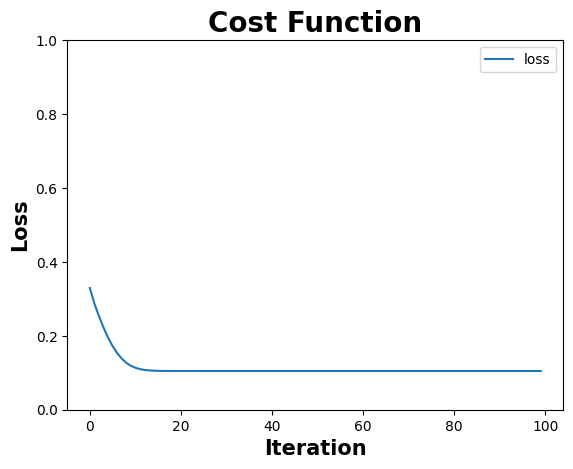

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
TN, FP, FN, TP: 896 0 104 0
Accuracy = 0.896
Precesion = nan
Recall = 0.0
F1 = 0.0
F0.5 = 0.0
F2 = 0.0
Gmean = 0.0
Balanced Accu. = 0.5
################################################## 2th CV ##################################################


<ipython-input-9-53e45a4ac5e7>:63: RuntimeWarning: invalid value encountered in scalar divide
  print('Precesion =', TP/(TP+FP))


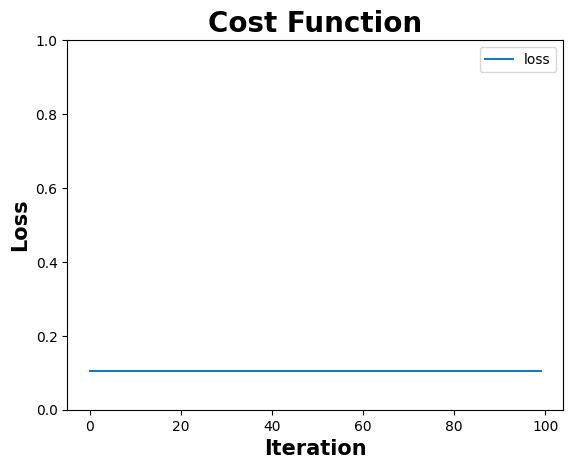

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
TN, FP, FN, TP: 896 0 104 0
Accuracy = 0.896
Precesion = nan
Recall = 0.0
F1 = 0.0
F0.5 = 0.0
F2 = 0.0
Gmean = 0.0
Balanced Accu. = 0.5
################################################## 3th CV ##################################################


<ipython-input-9-53e45a4ac5e7>:63: RuntimeWarning: invalid value encountered in scalar divide
  print('Precesion =', TP/(TP+FP))


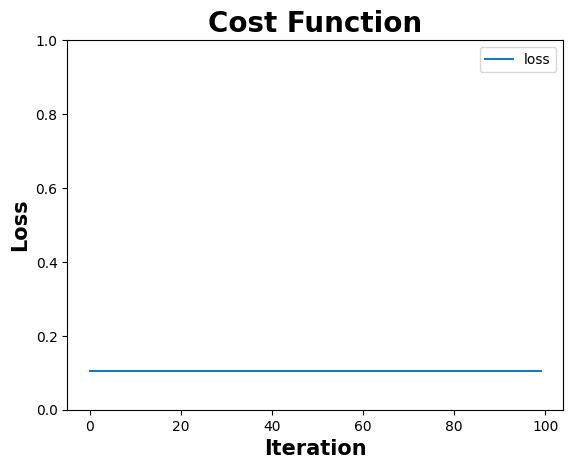

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
TN, FP, FN, TP: 896 0 104 0
Accuracy = 0.896
Precesion = nan
Recall = 0.0
F1 = 0.0
F0.5 = 0.0
F2 = 0.0
Gmean = 0.0
Balanced Accu. = 0.5
################################################## 4th CV ##################################################


<ipython-input-9-53e45a4ac5e7>:63: RuntimeWarning: invalid value encountered in scalar divide
  print('Precesion =', TP/(TP+FP))


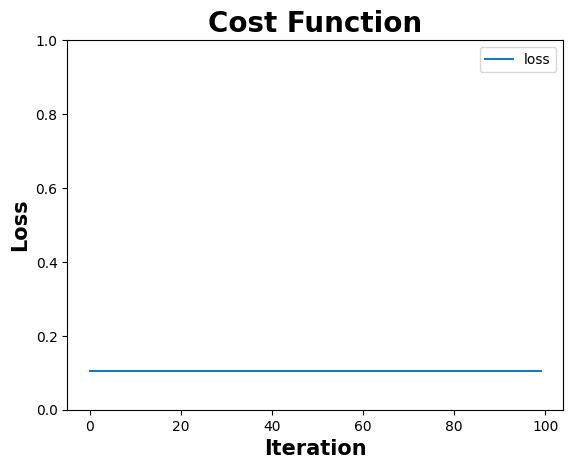

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
TN, FP, FN, TP: 895 0 105 0
Accuracy = 0.895
Precesion = nan
Recall = 0.0
F1 = 0.0
F0.5 = 0.0
F2 = 0.0
Gmean = 0.0
Balanced Accu. = 0.5
################################################## 5th CV ##################################################


<ipython-input-9-53e45a4ac5e7>:63: RuntimeWarning: invalid value encountered in scalar divide
  print('Precesion =', TP/(TP+FP))


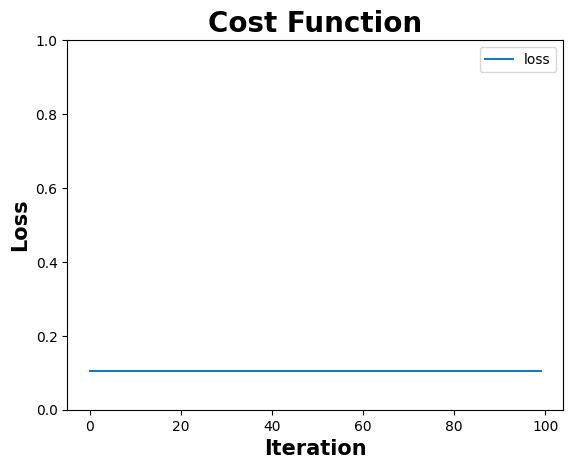

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
TN, FP, FN, TP: 895 0 105 0
Accuracy = 0.895
Precesion = nan
Recall = 0.0
F1 = 0.0
F0.5 = 0.0
F2 = 0.0
Gmean = 0.0
Balanced Accu. = 0.5
################################################## 6th CV ##################################################


<ipython-input-9-53e45a4ac5e7>:63: RuntimeWarning: invalid value encountered in scalar divide
  print('Precesion =', TP/(TP+FP))


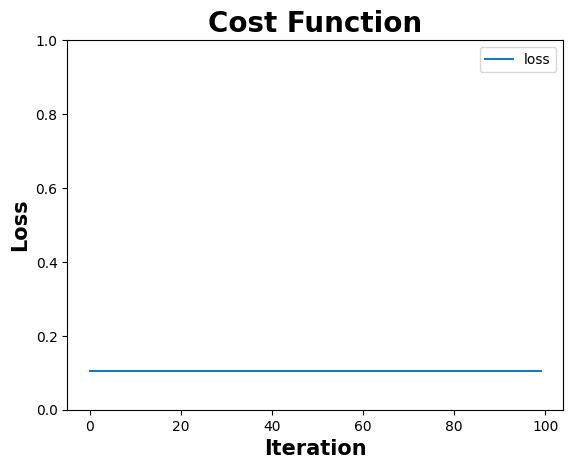

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
TN, FP, FN, TP: 895 0 105 0
Accuracy = 0.895
Precesion = nan
Recall = 0.0
F1 = 0.0
F0.5 = 0.0
F2 = 0.0
Gmean = 0.0
Balanced Accu. = 0.5
################################################## 7th CV ##################################################


<ipython-input-9-53e45a4ac5e7>:63: RuntimeWarning: invalid value encountered in scalar divide
  print('Precesion =', TP/(TP+FP))


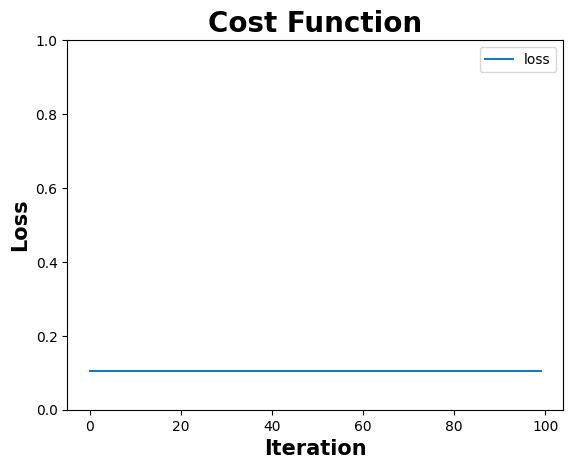

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
TN, FP, FN, TP: 895 0 105 0
Accuracy = 0.895
Precesion = nan
Recall = 0.0
F1 = 0.0
F0.5 = 0.0
F2 = 0.0
Gmean = 0.0
Balanced Accu. = 0.5
################################################## 8th CV ##################################################


<ipython-input-9-53e45a4ac5e7>:63: RuntimeWarning: invalid value encountered in scalar divide
  print('Precesion =', TP/(TP+FP))


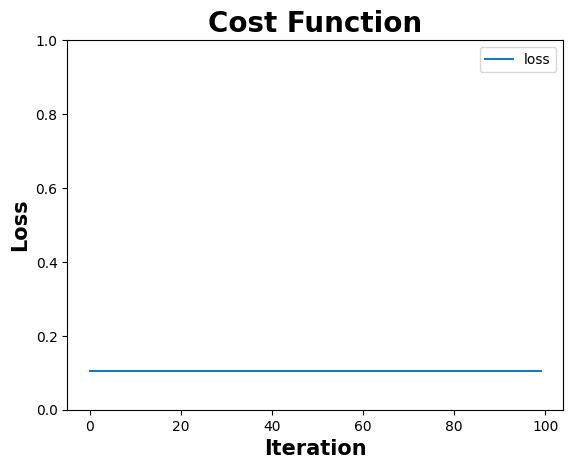

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
TN, FP, FN, TP: 895 0 105 0
Accuracy = 0.895
Precesion = nan
Recall = 0.0
F1 = 0.0
F0.5 = 0.0
F2 = 0.0
Gmean = 0.0
Balanced Accu. = 0.5
################################################## 9th CV ##################################################


<ipython-input-9-53e45a4ac5e7>:63: RuntimeWarning: invalid value encountered in scalar divide
  print('Precesion =', TP/(TP+FP))


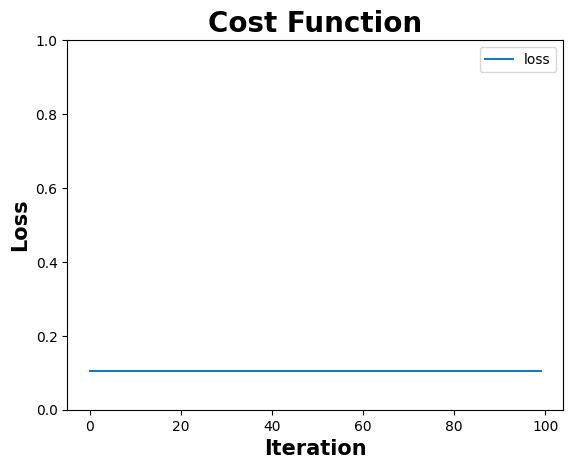

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
TN, FP, FN, TP: 895 0 105 0
Accuracy = 0.895
Precesion = nan
Recall = 0.0
F1 = 0.0
F0.5 = 0.0
F2 = 0.0
Gmean = 0.0
Balanced Accu. = 0.5
################################################## 10th CV ##################################################


<ipython-input-9-53e45a4ac5e7>:63: RuntimeWarning: invalid value encountered in scalar divide
  print('Precesion =', TP/(TP+FP))


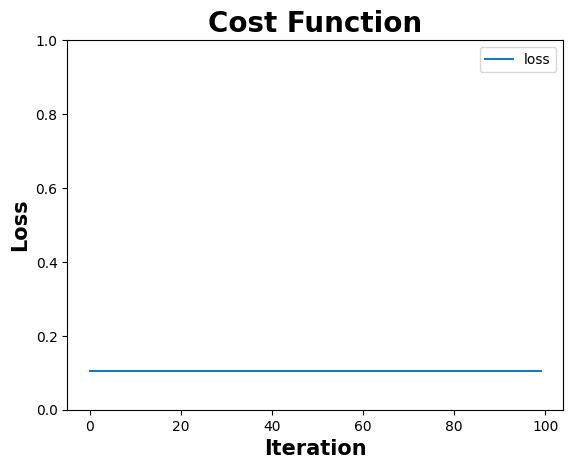

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
TN, FP, FN, TP: 895 0 105 0
Accuracy = 0.895
Precesion = nan
Recall = 0.0
F1 = 0.0
F0.5 = 0.0
F2 = 0.0
Gmean = 0.0
Balanced Accu. = 0.5


<ipython-input-9-53e45a4ac5e7>:63: RuntimeWarning: invalid value encountered in scalar divide
  print('Precesion =', TP/(TP+FP))


In [ ]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state = 2)

X = df_pca.iloc[:, :2]
y = df_pca.iloc[:, 2]

L = 73
hidden_node = 2
activation = 'sigmoid'
kernel_initializer=keras.initializers.he_normal(seed=100)
epochs=100

acc_acc = []
acc_f1 = []
acc_f5 = []
acc_f2 = []
acc_gmean = []
acc_bacc = []

n_iter=0

batch_size = int(X.shape[0]*0.9 * 0.05)
print('batch_size: ', batch_size)
learning_rate=0.001

model = Sequential()
model.add(Dense(hidden_node, input_dim=X.shape[1], kernel_initializer=kernel_initializer))
model.add(BatchNormalization())
model.add(Activation(activation))
model.add(Dense(1, activation='sigmoid'))
opt = optimizers.Adam(learning_rate = learning_rate)

for train_index, test_index in skf.split(df_pca, df_pca['target']):
    n_iter += 1
    X_train = X.iloc[train_index]
    y_train= y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test= y.iloc[test_index]
    print('#'*50,'{0}th CV'.format(n_iter),'#'*50)
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    y_train = y_train.astype(float)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    y_test = y_test.astype(float)

    model.compile(loss=SOL(score = 'accuracy', distribution = 'cosine', mu = 0.5, delta = 0.1, mode = 'average'))
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, verbose=0, batch_size=batch_size)
    plt.plot(history.history['loss'], label='loss')
    plt.ylim([0, 1])
    plt.xlabel('Iteration',fontweight="bold",fontsize = 15)
    plt.ylabel('Loss',fontweight="bold",fontsize = 15)
    plt.title("Cost Function",fontweight="bold",fontsize = 20)
    plt.legend()
    plt.show()
    predicted = np.round(model.predict(X_test))
    TN = metrics.confusion_matrix(y_test, predicted)[0,0]
    FP = metrics.confusion_matrix(y_test, predicted)[0,1]
    FN = metrics.confusion_matrix(y_test, predicted)[1,0]
    TP = metrics.confusion_matrix(y_test, predicted)[1,1]
    print("TN, FP, FN, TP:", TN, FP, FN, TP)
    print('Accuracy =', (TP+TN)/(TP+TN+FP+FN))
    print('Precesion =', TP/(TP+FP))
    print('Recall =', TP/(TP+FN))
    print('F1 =', TP / (TP + 0.5*(FP+FN)))
    print('F0.5 =', TP / (TP + 0.8*FP + 0.2*FN))
    print('F2 =', TP / (TP + 0.2*FP + 0.8*FN))
    print('Gmean =', ((TP/(TP+FN)) * (TN/(TN+FP)))**0.5)
    print('Balanced Accu. =', 0.5*(TP/(TP+FN) + TN/(TN+FP)))
    acc_acc.append((TP+TN)/(TP+TN+FP+FN))
    acc_f1.append(TP / (TP + 0.5*(FP+FN)))
    acc_f5.append(TP / (TP + 0.8*FP + 0.2*FN))
    acc_f2.append(TP / (TP + 0.2*FP + 0.8*FN))
    acc_gmean.append(((TP/(TP+FN)) * (TN/(TN+FP)))**0.5)
    acc_bacc.append(0.5*(TP/(TP+FN) + TN/(TN+FP)))

In [ ]:
res['AccAim'] = [np.mean(acc_acc), np.mean(acc_f1), np.mean(acc_f5), np.mean(acc_f2), np.mean(acc_gmean), np.mean(acc_bacc)]
res

,Delta,BCE,AccAim,F1Aim,F.5Aim,F2Aim,GAim,BAim
Acc,0,0,0.8953,0,0,0,0,0
F1,0,0,0.0000,0,0,0,0,0
F.5,0,0,0.0000,0,0,0,0,0
F2,0,0,0.0000,0,0,0,0,0
Gmean,0,0,0.0000,0,0,0,0,0
B_Acc,0,0,0.5000,0,0,0,0,0


batch_size:  450
################################################## 1th CV ##################################################


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


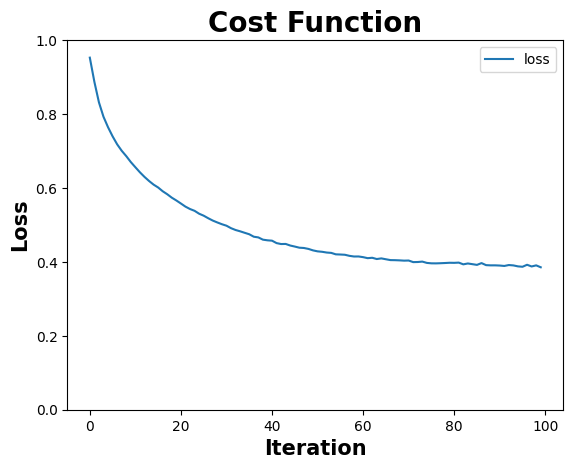

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
TN, FP, FN, TP: 828 68 28 76
Accuracy = 0.904
Precesion = 0.5277777777777778
Recall = 0.7307692307692307
F1 = 0.6129032258064516
F0.5 = 0.5588235294117647
F2 = 0.6785714285714286
Gmean = 0.821771906269657
Balanced Accu. = 0.8274381868131868
################################################## 2th CV ##################################################


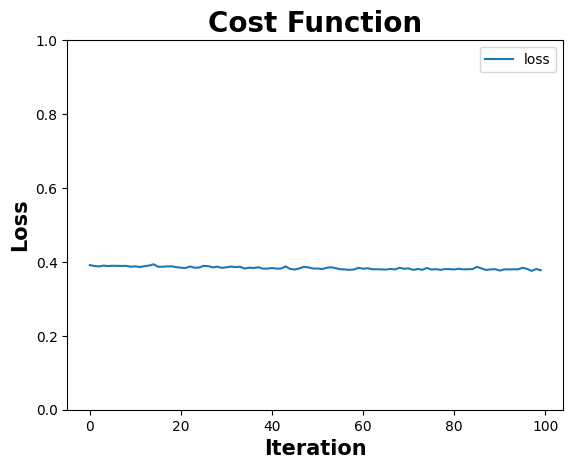

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
TN, FP, FN, TP: 835 61 24 80
Accuracy = 0.915
Precesion = 0.5673758865248227
Recall = 0.7692307692307693
F1 = 0.6530612244897959
F0.5 = 0.5988023952095808
F2 = 0.718132854578097
Gmean = 0.8466765992610542
Balanced Accu. = 0.8505752060439561
################################################## 3th CV ##################################################


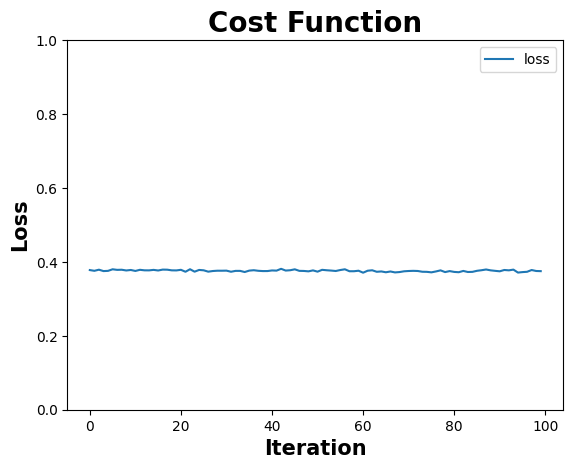

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
TN, FP, FN, TP: 844 52 27 77
Accuracy = 0.921
Precesion = 0.5968992248062015
Recall = 0.7403846153846154
F1 = 0.6609442060085837
F0.5 = 0.6209677419354839
F2 = 0.7064220183486238
Gmean = 0.8351142828287728
Balanced Accu. = 0.8411744505494505
################################################## 4th CV ##################################################


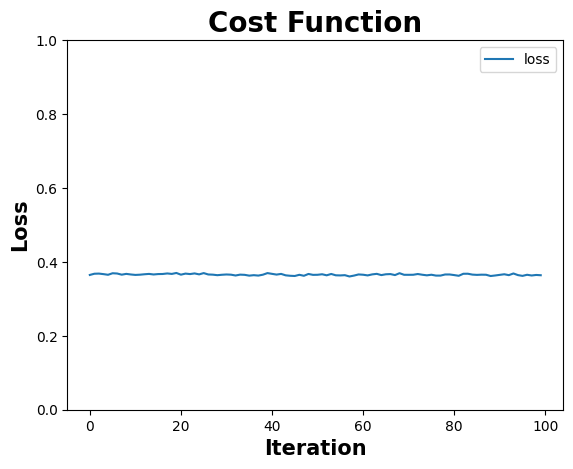

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
TN, FP, FN, TP: 841 54 46 59
Accuracy = 0.9
Precesion = 0.5221238938053098
Recall = 0.5619047619047619
F1 = 0.5412844036697247
F0.5 = 0.5296229802513465
F2 = 0.5534709193245779
Gmean = 0.7266375494189602
Balanced Accu. = 0.7507847831870178
################################################## 5th CV ##################################################


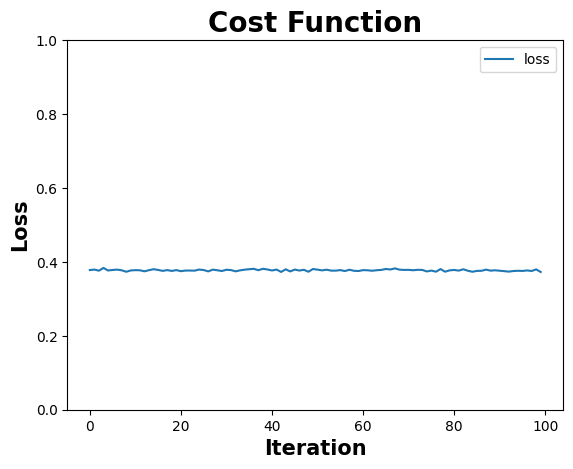

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
TN, FP, FN, TP: 855 40 28 77
Accuracy = 0.932
Precesion = 0.6581196581196581
Recall = 0.7333333333333333
F1 = 0.6936936936936937
F0.5 = 0.6719022687609075
F2 = 0.7169459962756052
Gmean = 0.8369938226880035
Balanced Accu. = 0.8443202979515829
################################################## 6th CV ##################################################


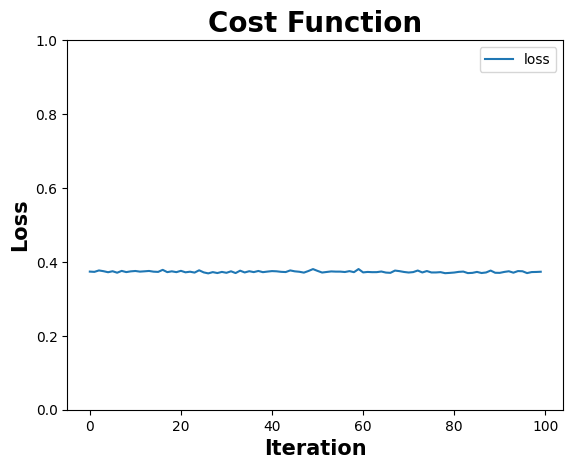

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
TN, FP, FN, TP: 840 55 22 83
Accuracy = 0.923
Precesion = 0.6014492753623188
Recall = 0.7904761904761904
F1 = 0.6831275720164609
F0.5 = 0.6316590563165906
F2 = 0.7437275985663083
Gmean = 0.86133584700788
Balanced Accu. = 0.864511838254855
################################################## 7th CV ##################################################


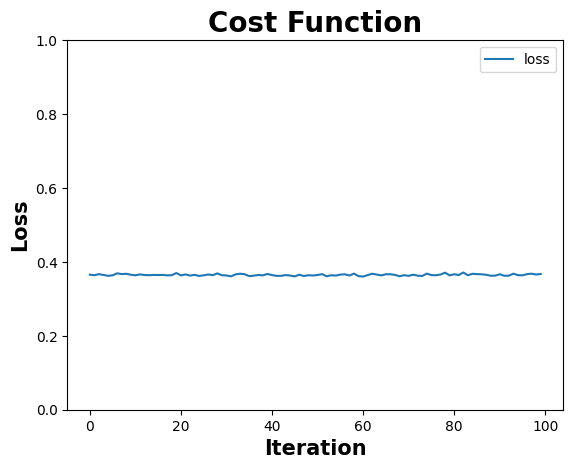

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
TN, FP, FN, TP: 843 52 36 69
Accuracy = 0.912
Precesion = 0.5702479338842975
Recall = 0.6571428571428571
F1 = 0.6106194690265486
F0.5 = 0.5857385398981324
F2 = 0.6377079482439926
Gmean = 0.7867416920590535
Balanced Accu. = 0.7995211492418196
################################################## 8th CV ##################################################


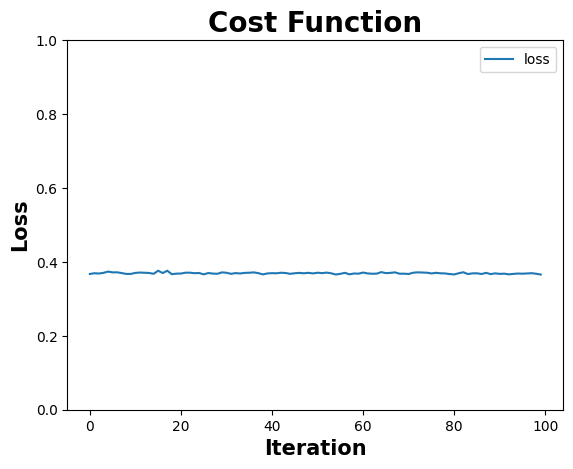

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
TN, FP, FN, TP: 835 60 28 77
Accuracy = 0.912
Precesion = 0.5620437956204379
Recall = 0.7333333333333333
F1 = 0.6363636363636364
F0.5 = 0.5895865237366004
F2 = 0.6912028725314183
Gmean = 0.8271464937725052
Balanced Accu. = 0.8331471135940409
################################################## 9th CV ##################################################


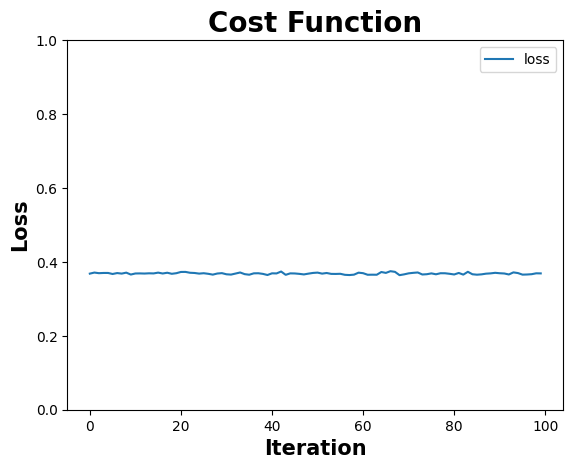

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
TN, FP, FN, TP: 837 58 27 78
Accuracy = 0.915
Precesion = 0.5735294117647058
Recall = 0.7428571428571429
F1 = 0.6473029045643154
F0.5 = 0.6009244992295839
F2 = 0.7014388489208634
Gmean = 0.8334966586424187
Balanced Accu. = 0.8390263367916999
################################################## 10th CV ##################################################


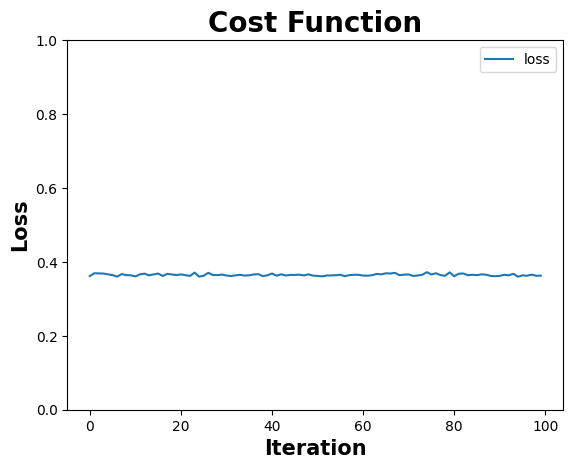

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
TN, FP, FN, TP: 836 59 34 71
Accuracy = 0.907
Precesion = 0.5461538461538461
Recall = 0.6761904761904762
F1 = 0.6042553191489362
F0.5 = 0.568
F2 = 0.6454545454545455
Gmean = 0.7947419651483516
Balanced Accu. = 0.8051343442404895


In [ ]:
f1_acc = []
f1_f1 = []
f1_f5 = []
f1_f2 = []
f1_gmean = []
f1_bacc = []
n_iter=0

batch_size = int(X.shape[0]*0.9 * 0.05)
print('batch_size: ', batch_size)
learning_rate=0.001

model = Sequential()
model.add(Dense(hidden_node, input_dim=X.shape[1], kernel_initializer=kernel_initializer))
model.add(BatchNormalization())
model.add(Activation(activation))
model.add(Dense(1, activation='sigmoid'))
opt = optimizers.Adam(learning_rate = learning_rate)   # SGD(learning_rate=learning_rate, momentum=momentum)

for train_index, test_index in skf.split(df_pca, df_pca['target']):
    n_iter += 1
    X_train = X.iloc[train_index]
    y_train= y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test= y.iloc[test_index]
    print('#'*50,'{0}th CV'.format(n_iter),'#'*50)
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    y_train = y_train.astype(float)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    y_test = y_test.astype(float)

    model.compile(loss=SOL(score = 'f1_score', distribution = 'cosine', mu = 0.5, delta = 0.1, mode = 'average'))
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, verbose=0, batch_size=batch_size)
    plt.plot(history.history['loss'], label='loss')
    plt.ylim([0, 1])
    plt.xlabel('Iteration',fontweight="bold",fontsize = 15)
    plt.ylabel('Loss',fontweight="bold",fontsize = 15)
    plt.title("Cost Function",fontweight="bold",fontsize = 20)
    plt.legend()
    plt.show()
    predicted = np.round(model.predict(X_test))
    TN = metrics.confusion_matrix(y_test, predicted)[0,0]
    FP = metrics.confusion_matrix(y_test, predicted)[0,1]
    FN = metrics.confusion_matrix(y_test, predicted)[1,0]
    TP = metrics.confusion_matrix(y_test, predicted)[1,1]
    print("TN, FP, FN, TP:", TN, FP, FN, TP)
    print('Accuracy =', (TP+TN)/(TP+TN+FP+FN))
    print('Precesion =', TP/(TP+FP))
    print('Recall =', TP/(TP+FN))
    print('F1 =', TP / (TP + 0.5*(FP+FN)))
    print('F0.5 =', TP / (TP + 0.8*FP + 0.2*FN))
    print('F2 =', TP / (TP + 0.2*FP + 0.8*FN))
    print('Gmean =', ((TP/(TP+FN)) * (TN/(TN+FP)))**0.5)
    print('Balanced Accu. =', 0.5*(TP/(TP+FN) + TN/(TN+FP)))
    f1_acc.append((TP+TN)/(TP+TN+FP+FN))
    f1_f1.append(TP / (TP + 0.5*(FP+FN)))
    f1_f5.append(TP / (TP + 0.8*FP + 0.2*FN))
    f1_f2.append(TP / (TP + 0.2*FP + 0.8*FN))
    f1_gmean.append(((TP/(TP+FN)) * (TN/(TN+FP)))**0.5)
    f1_bacc.append(0.5*(TP/(TP+FN) + TN/(TN+FP)))

In [ ]:
res['F1Aim'] = [np.mean(f1_acc), np.mean(f1_f1), np.mean(f1_f5), np.mean(f1_f2), np.mean(f1_gmean), np.mean(f1_bacc)]
res

,Delta,BCE,AccAim,F1Aim,F.5Aim,F2Aim,GAim,BAim
Acc,0,0,0.8953,0.914100,0,0,0,0
F1,0,0,0.0000,0.634356,0,0,0,0
F.5,0,0,0.0000,0.595603,0,0,0,0
F2,0,0,0.0000,0.679308,0,0,0,0
Gmean,0,0,0.0000,0.817066,0,0,0,0
B_Acc,0,0,0.5000,0.825563,0,0,0,0


batch_size:  4500
################################################## 1th CV ##################################################


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


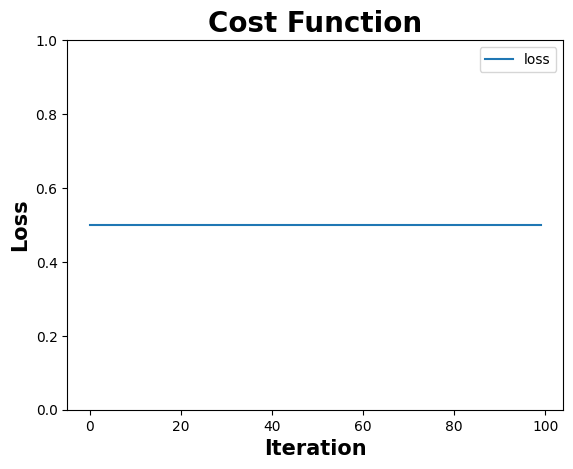

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
TN, FP, FN, TP: 896 0 104 0
Accuracy = 0.896
Precesion = nan
Recall = 0.0
F1 = 0.0
F0.5 = 0.0
F2 = 0.0
Gmean = 0.0
Balanced Accu. = 0.5
################################################## 2th CV ##################################################


<ipython-input-13-8d471fc93a89>:50: RuntimeWarning: invalid value encountered in scalar divide
  print('Precesion =', TP/(TP+FP))


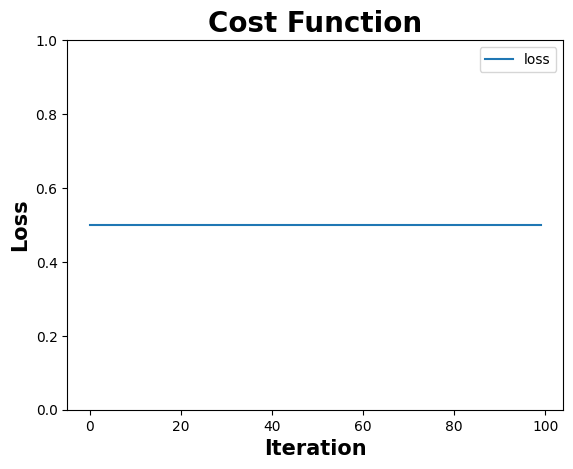

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
TN, FP, FN, TP: 896 0 104 0
Accuracy = 0.896
Precesion = nan
Recall = 0.0
F1 = 0.0
F0.5 = 0.0
F2 = 0.0
Gmean = 0.0
Balanced Accu. = 0.5
################################################## 3th CV ##################################################


<ipython-input-13-8d471fc93a89>:50: RuntimeWarning: invalid value encountered in scalar divide
  print('Precesion =', TP/(TP+FP))


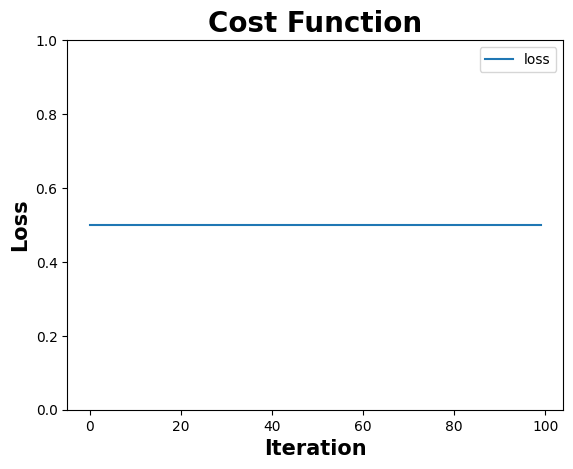

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
TN, FP, FN, TP: 896 0 104 0
Accuracy = 0.896
Precesion = nan
Recall = 0.0
F1 = 0.0
F0.5 = 0.0
F2 = 0.0
Gmean = 0.0
Balanced Accu. = 0.5
################################################## 4th CV ##################################################


<ipython-input-13-8d471fc93a89>:50: RuntimeWarning: invalid value encountered in scalar divide
  print('Precesion =', TP/(TP+FP))


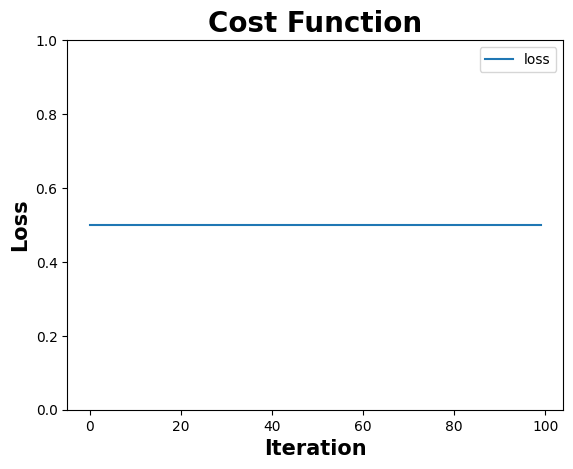

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
TN, FP, FN, TP: 895 0 105 0
Accuracy = 0.895
Precesion = nan
Recall = 0.0
F1 = 0.0
F0.5 = 0.0
F2 = 0.0
Gmean = 0.0
Balanced Accu. = 0.5
################################################## 5th CV ##################################################


<ipython-input-13-8d471fc93a89>:50: RuntimeWarning: invalid value encountered in scalar divide
  print('Precesion =', TP/(TP+FP))


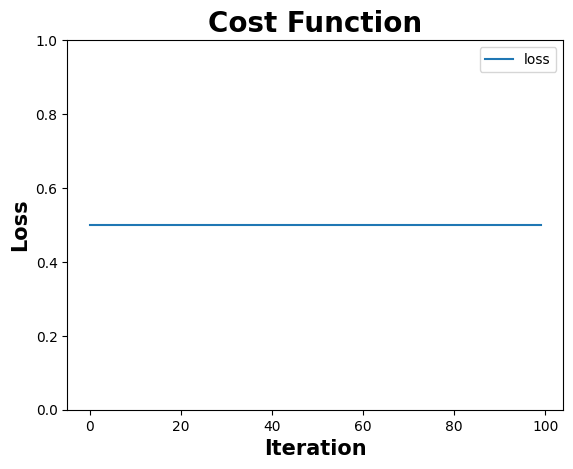

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
TN, FP, FN, TP: 895 0 105 0
Accuracy = 0.895
Precesion = nan
Recall = 0.0
F1 = 0.0
F0.5 = 0.0
F2 = 0.0
Gmean = 0.0
Balanced Accu. = 0.5
################################################## 6th CV ##################################################


<ipython-input-13-8d471fc93a89>:50: RuntimeWarning: invalid value encountered in scalar divide
  print('Precesion =', TP/(TP+FP))


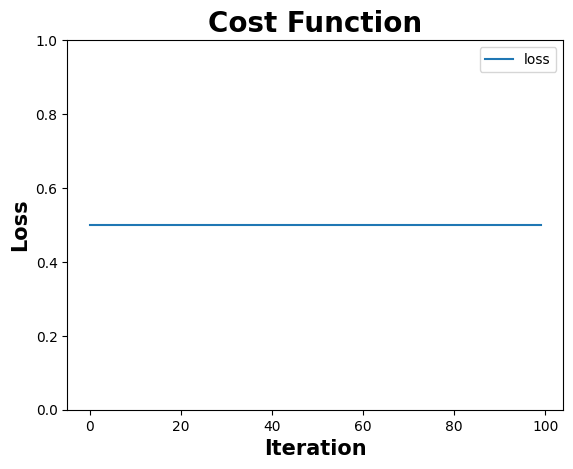

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
TN, FP, FN, TP: 895 0 105 0
Accuracy = 0.895
Precesion = nan
Recall = 0.0
F1 = 0.0
F0.5 = 0.0
F2 = 0.0
Gmean = 0.0
Balanced Accu. = 0.5
################################################## 7th CV ##################################################


<ipython-input-13-8d471fc93a89>:50: RuntimeWarning: invalid value encountered in scalar divide
  print('Precesion =', TP/(TP+FP))


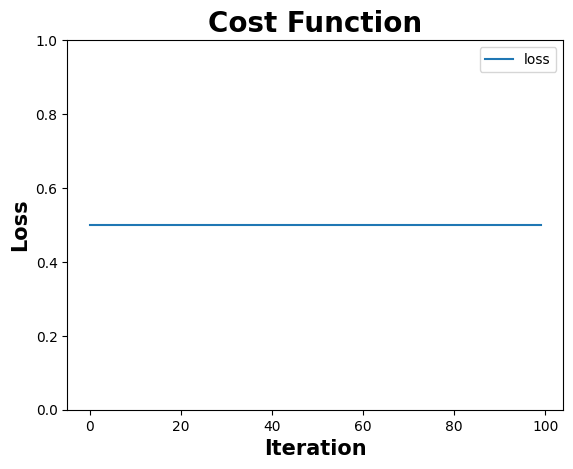

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
TN, FP, FN, TP: 895 0 105 0
Accuracy = 0.895
Precesion = nan
Recall = 0.0
F1 = 0.0
F0.5 = 0.0
F2 = 0.0
Gmean = 0.0
Balanced Accu. = 0.5
################################################## 8th CV ##################################################


<ipython-input-13-8d471fc93a89>:50: RuntimeWarning: invalid value encountered in scalar divide
  print('Precesion =', TP/(TP+FP))


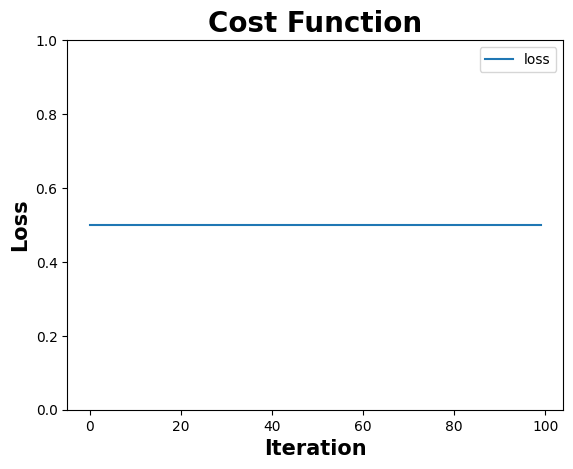

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
TN, FP, FN, TP: 895 0 105 0
Accuracy = 0.895
Precesion = nan
Recall = 0.0
F1 = 0.0
F0.5 = 0.0
F2 = 0.0
Gmean = 0.0
Balanced Accu. = 0.5
################################################## 9th CV ##################################################


<ipython-input-13-8d471fc93a89>:50: RuntimeWarning: invalid value encountered in scalar divide
  print('Precesion =', TP/(TP+FP))


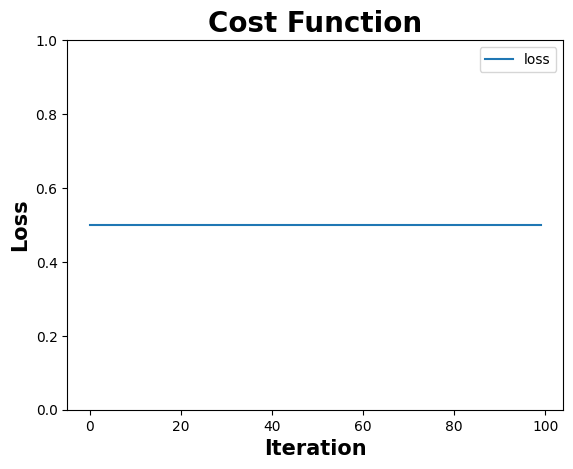

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
TN, FP, FN, TP: 895 0 105 0
Accuracy = 0.895
Precesion = nan
Recall = 0.0
F1 = 0.0
F0.5 = 0.0
F2 = 0.0
Gmean = 0.0
Balanced Accu. = 0.5
################################################## 10th CV ##################################################


<ipython-input-13-8d471fc93a89>:50: RuntimeWarning: invalid value encountered in scalar divide
  print('Precesion =', TP/(TP+FP))


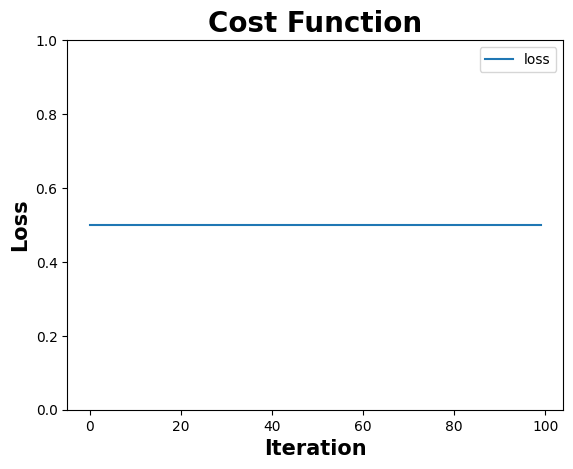

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
TN, FP, FN, TP: 895 0 105 0
Accuracy = 0.895
Precesion = nan
Recall = 0.0
F1 = 0.0
F0.5 = 0.0
F2 = 0.0
Gmean = 0.0
Balanced Accu. = 0.5


<ipython-input-13-8d471fc93a89>:50: RuntimeWarning: invalid value encountered in scalar divide
  print('Precesion =', TP/(TP+FP))


In [ ]:
bacc_acc = []
bacc_f1 = []
bacc_f5 = []
bacc_f2 = []
bacc_gmean = []
bacc_bacc = []

n_iter=0
batch_size = int(X.shape[0]*0.9 * 0.5)
print('batch_size: ', batch_size)
learning_rate=0.02

model = Sequential()
model.add(Dense(hidden_node, input_dim=X.shape[1], kernel_initializer=kernel_initializer))
model.add(BatchNormalization())
model.add(Activation(activation))
model.add(Dense(1, activation='sigmoid'))
opt = optimizers.Adam(learning_rate = learning_rate)   # SGD(learning_rate=learning_rate, momentum=momentum)

for train_index, test_index in skf.split(df_pca, df_pca['target']):
    n_iter += 1
    X_train = X.iloc[train_index]
    y_train= y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test= y.iloc[test_index]
    print('#'*50,'{0}th CV'.format(n_iter),'#'*50)
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    y_train = y_train.astype(float)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    y_test = y_test.astype(float)

    model.compile(loss=SOL(score = 'bacc', distribution = 'cosine', mu = 0.5, delta = 0.1, mode = 'average'))
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, verbose=0, batch_size=batch_size)
    plt.plot(history.history['loss'], label='loss')
    plt.ylim([0, 1])
    plt.xlabel('Iteration',fontweight="bold",fontsize = 15)
    plt.ylabel('Loss',fontweight="bold",fontsize = 15)
    plt.title("Cost Function",fontweight="bold",fontsize = 20)
    plt.legend()
    plt.show()
    predicted = np.round(model.predict(X_test))
    TN = metrics.confusion_matrix(y_test, predicted)[0,0]
    FP = metrics.confusion_matrix(y_test, predicted)[0,1]
    FN = metrics.confusion_matrix(y_test, predicted)[1,0]
    TP = metrics.confusion_matrix(y_test, predicted)[1,1]
    print("TN, FP, FN, TP:", TN, FP, FN, TP)
    print('Accuracy =', (TP+TN)/(TP+TN+FP+FN))
    print('Precesion =', TP/(TP+FP))
    print('Recall =', TP/(TP+FN))
    print('F1 =', TP / (TP + 0.5*(FP+FN)))
    print('F0.5 =', TP / (TP + 0.8*FP + 0.2*FN))
    print('F2 =', TP / (TP + 0.2*FP + 0.8*FN))
    print('Gmean =', ((TP/(TP+FN)) * (TN/(TN+FP)))**0.5)
    print('Balanced Accu. =', 0.5*(TP/(TP+FN) + TN/(TN+FP)))
    bacc_acc.append((TP+TN)/(TP+TN+FP+FN))
    bacc_f1.append(TP / (TP + 0.5*(FP+FN)))
    bacc_f5.append(TP / (TP + 0.8*FP + 0.2*FN))
    bacc_f2.append(TP / (TP + 0.2*FP + 0.8*FN))
    bacc_gmean.append(((TP/(TP+FN)) * (TN/(TN+FP)))**0.5)
    bacc_bacc.append(0.5*(TP/(TP+FN) + TN/(TN+FP)))

In [ ]:
res['BAim'] = [np.mean(bacc_acc), np.mean(bacc_f1), np.mean(bacc_f5), np.mean(bacc_f2), np.mean(bacc_gmean), np.mean(bacc_bacc)]
res

,Delta,BCE,AccAim,F1Aim,F.5Aim,F2Aim,GAim,BAim
Acc,0,0,0.8953,0.914100,0,0,0,0.8953
F1,0,0,0.0000,0.634356,0,0,0,0.0000
F.5,0,0,0.0000,0.595603,0,0,0,0.0000
F2,0,0,0.0000,0.679308,0,0,0,0.0000
Gmean,0,0,0.0000,0.817066,0,0,0,0.0000
B_Acc,0,0,0.5000,0.825563,0,0,0,0.5000


# **2. BREAST-CANCER DATASET**

In [ ]:
cancer_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Major-project-8th-sem/breast_cancer.csv')
cancer_df.shape

(569, 32)

In [ ]:
cancer_df.isnull().sum()


,0
id,0
diagnosis,0
radius_mean,0
texture_mean,0
perimeter_mean,0
area_mean,0
smoothness_mean,0
compactness_mean,0
concavity_mean,0
concave points_mean,0


In [ ]:
 cancer_df.head()


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [ ]:
y_encoded, y_class = pd.factorize(cancer_df['diagnosis'])
print(y_class)
y_encoded = (y_encoded+1)%2
y_encoded

Index(['M', 'B'], dtype='object')


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,

In [ ]:
cancer_df['label'] = y_encoded
cancer_df

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,label
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,1
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,1
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,1
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,1
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,1
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,1
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,1
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,1


In [ ]:
cancer_df = cancer_df.drop('id', axis=1)
cancer_df = cancer_df.drop('diagnosis', axis=1)
cancer_df

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,label
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,1
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,1
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,1
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,1
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,1
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,1
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,1
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,1


In [ ]:
cancer_df.iloc[:,:-1] = (cancer_df.iloc[:,:-1] - cancer_df.iloc[:,:-1].mean())/cancer_df.iloc[:,:-1].std()

cancer_df

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,label
0,1.096100,-2.071512,1.268817,0.983510,1.567087,3.280628,2.650542,2.530249,2.215566,2.253764,...,-1.358098,2.301575,1.999478,1.306537,2.614365,2.107672,2.294058,2.748204,1.935312,1
1,1.828212,-0.353322,1.684473,1.907030,-0.826235,-0.486643,-0.023825,0.547662,0.001391,-0.867889,...,-0.368879,1.533776,1.888827,-0.375282,-0.430066,-0.146620,1.086129,-0.243675,0.280943,1
2,1.578499,0.455786,1.565126,1.557513,0.941382,1.052000,1.362280,2.035440,0.938859,-0.397658,...,-0.023953,1.346291,1.455004,0.526944,1.081980,0.854222,1.953282,1.151242,0.201214,1
3,-0.768233,0.253509,-0.592166,-0.763792,3.280667,3.399917,1.914213,1.450431,2.864862,4.906602,...,0.133866,-0.249720,-0.549538,3.391291,3.889975,1.987839,2.173873,6.040726,4.930672,1
4,1.748758,-1.150804,1.775011,1.824624,0.280125,0.538866,1.369806,1.427237,-0.009552,-0.561956,...,-1.465481,1.337363,1.219651,0.220362,-0.313119,0.612640,0.728618,-0.867590,-0.396751,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,2.109139,0.720838,2.058974,2.341795,1.040926,0.218868,1.945573,2.318924,-0.312314,-0.930209,...,0.117596,1.751022,2.013529,0.378033,-0.273077,0.663928,1.627719,-1.358963,-0.708467,1
565,1.703356,2.083301,1.614511,1.722326,0.102368,-0.017817,0.692434,1.262558,-0.217473,-1.057681,...,2.045599,1.420690,1.493644,-0.690623,-0.394473,0.236365,0.733182,-0.531387,-0.973122,1
566,0.701667,2.043775,0.672084,0.577445,-0.839745,-0.038646,0.046547,0.105684,-0.808406,-0.894800,...,1.373645,0.578492,0.427529,-0.808876,0.350427,0.326479,0.413705,-1.103578,-0.318129,1
567,1.836725,2.334403,1.980781,1.733693,1.524426,3.269267,3.294046,2.656528,2.135315,1.042778,...,2.235958,2.301575,1.651717,1.429169,3.901415,3.194794,2.287972,1.917396,2.217684,1


In [ ]:
cancer_df['label'].value_counts()


,count
label,
0,357
1,212


In [ ]:
df_0 = cancer_df[cancer_df['label']==0]
df_1 = cancer_df[cancer_df['label']==1]
print(len(df_0), len(df_1))

357 212


In [ ]:
N = round(len(df_0)*0.1)
df_1_samp = df_1.sample(n=N, random_state = 100)
df_1_samp

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,label
219,1.533097,3.064460,1.482818,1.614345,-0.864631,0.163957,0.322388,0.449731,-1.399339,-1.369279,...,3.210535,2.170633,2.803894,0.369273,0.987914,0.610243,0.728618,-0.303481,-0.457654,1
45,1.283384,-0.392847,1.305856,1.196630,0.962713,1.216733,1.362280,1.339615,0.347926,-0.326840,...,-0.708923,1.289747,1.205600,1.556182,1.619046,2.216001,1.874173,1.451885,0.437632,1
408,1.096100,0.318610,1.063047,0.957083,0.514765,0.493423,0.392634,1.013350,0.657983,-0.298513,...,-0.043477,0.917752,0.822712,0.693374,0.757834,0.277588,1.259559,0.257396,0.060028,1
156,1.008133,0.337210,1.046586,0.877518,1.076478,1.176970,1.213007,1.455585,0.581381,-0.161126,...,-0.092288,0.763001,0.740163,0.413071,0.607202,0.412759,0.561273,-0.707570,-0.363530,1
213,0.934354,1.457870,0.927239,0.832905,0.301456,0.194253,0.995997,0.439423,-1.837067,-0.586034,...,0.389306,0.391006,0.246624,-0.353383,-0.476463,0.038881,-0.071597,-2.097638,-0.872908,1
100,-0.146789,1.323019,-0.161284,-0.205133,-0.105252,-0.364135,-0.031978,-0.103836,-0.739099,-0.578952,...,1.560751,0.039842,0.045520,-0.257029,-0.381126,0.214316,0.057716,-0.403695,-0.552332,1
372,2.055224,-0.974102,2.030166,2.077526,0.265905,0.892947,1.309595,1.973589,0.588676,-0.137048,...,-0.624319,1.334387,1.149396,-0.576750,0.188990,0.624144,1.247389,-0.276002,0.150276,1
212,3.967796,-0.190570,3.972634,5.240230,1.268455,0.894841,2.901420,2.849813,-0.596837,-1.069012,...,-1.172620,2.417638,2.842534,-0.795736,-0.652519,0.229655,0.682979,-2.024902,-1.588804,1
433,1.331624,0.623187,1.305856,1.293244,0.386780,0.654369,0.885610,0.992733,0.479244,-0.209282,...,0.854630,1.132021,1.268829,0.290438,0.584956,0.570459,0.854888,0.171729,-0.044616,1
365,1.791323,0.579012,1.721511,1.813257,-0.345580,0.165850,0.115287,0.745586,-0.706269,-1.023688,...,0.112715,1.605200,1.579706,0.014515,-0.105920,-0.009531,0.941603,-0.471582,-0.918862,1


In [ ]:
res = pd.DataFrame({'Delta':[0, 0, 0, 0, 0, 0],
                    'BCE':[0, 0, 0, 0, 0, 0],
                    'AccAim':[0, 0, 0, 0, 0, 0],
                    'F1Aim':[0, 0, 0, 0, 0, 0],
                    'F.5Aim':[0, 0, 0, 0, 0, 0],
                    'F2Aim':[0, 0, 0, 0, 0, 0],
                    'GAim':[0, 0, 0, 0, 0, 0],
                    'BAim':[0, 0, 0, 0, 0, 0]}, index = ['Acc','F1','F.5','F2','Gmean','B_Acc'])

batch_size:  25
################################################## 1th CV ##################################################


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


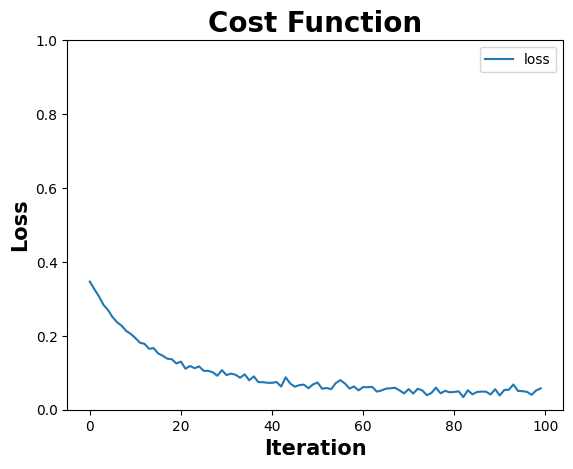

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
TN, FP, FN, TP: 34 1 1 21
Accuracy = 0.9649122807017544
Precesion = 0.9545454545454546
Recall = 0.9545454545454546
F1 = 0.9545454545454546
F0.5 = 0.9545454545454546
F2 = 0.9545454545454546
Gmean = 0.9629500128629352
Balanced Accu. = 0.9629870129870131
################################################## 2th CV ##################################################


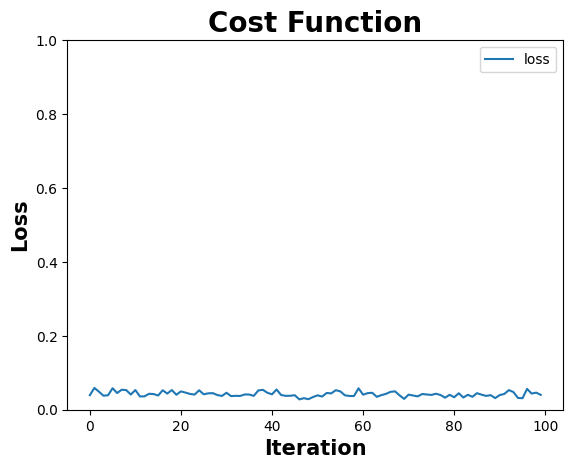

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 839ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step
TN, FP, FN, TP: 35 0 1 21
Accuracy = 0.9824561403508771
Precesion = 1.0
Recall = 0.9545454545454546
F1 = 0.9767441860465116
F0.5 = 0.9905660377358491
F2 = 0.963302752293578
Gmean = 0.9770084209183945
Balanced Accu. = 0.9772727272727273
################################################## 3th CV ##################################################


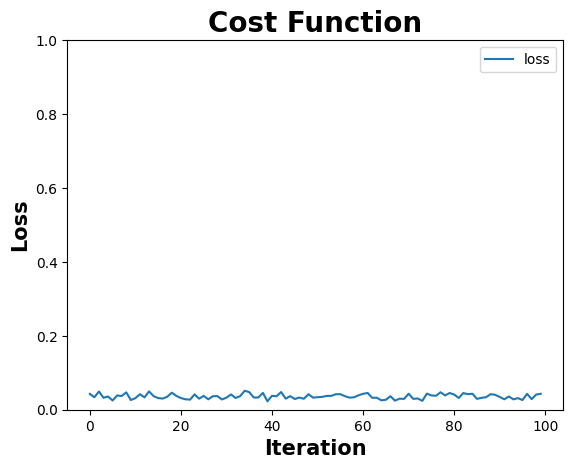

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
TN, FP, FN, TP: 36 0 2 19
Accuracy = 0.9649122807017544
Precesion = 1.0
Recall = 0.9047619047619048
F1 = 0.95
F0.5 = 0.9793814432989691
F2 = 0.9223300970873786
Gmean = 0.9511897312113419
Balanced Accu. = 0.9523809523809523
################################################## 4th CV ##################################################


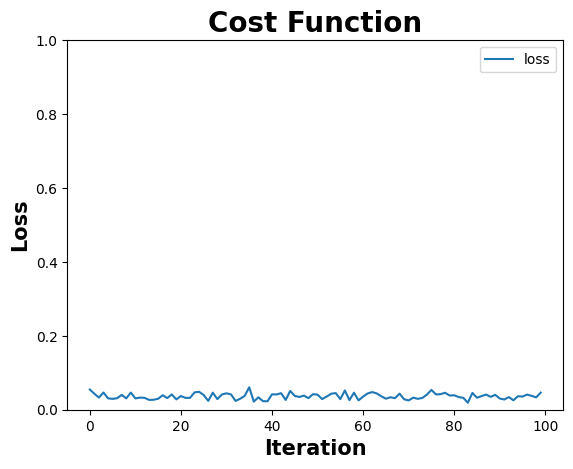

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
TN, FP, FN, TP: 36 0 1 20
Accuracy = 0.9824561403508771
Precesion = 1.0
Recall = 0.9523809523809523
F1 = 0.975609756097561
F0.5 = 0.9900990099009901
F2 = 0.9615384615384615
Gmean = 0.9759000729485332
Balanced Accu. = 0.9761904761904762
################################################## 5th CV ##################################################


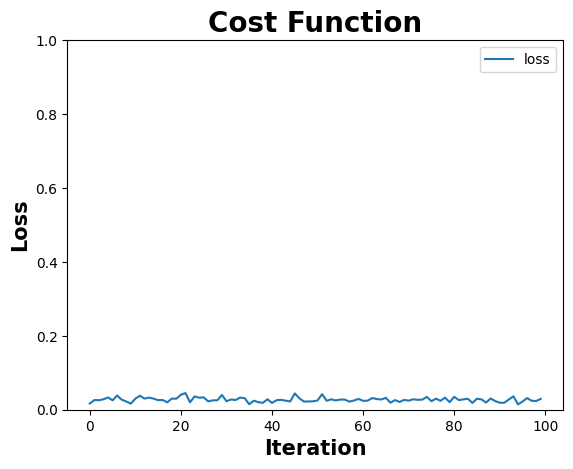

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
TN, FP, FN, TP: 35 1 4 17
Accuracy = 0.9122807017543859
Precesion = 0.9444444444444444
Recall = 0.8095238095238095
F1 = 0.8717948717948718
F0.5 = 0.9139784946236559
F2 = 0.8333333333333334
Gmean = 0.8871510790372952
Balanced Accu. = 0.8908730158730158
################################################## 6th CV ##################################################


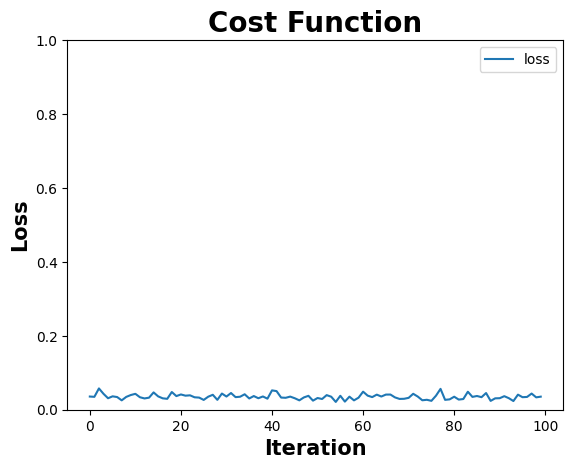

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
TN, FP, FN, TP: 36 0 0 21
Accuracy = 1.0
Precesion = 1.0
Recall = 1.0
F1 = 1.0
F0.5 = 1.0
F2 = 1.0
Gmean = 1.0
Balanced Accu. = 1.0
################################################## 7th CV ##################################################


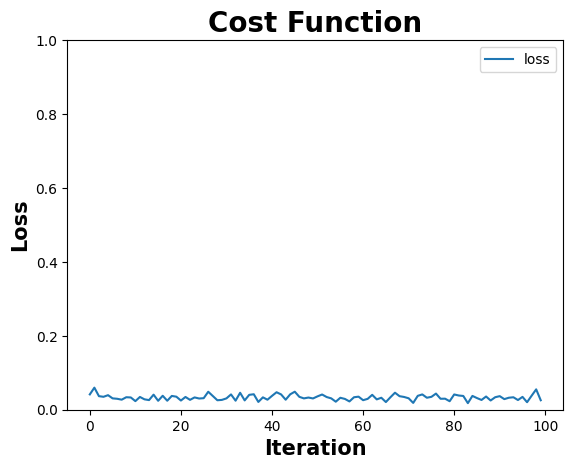

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
TN, FP, FN, TP: 35 1 0 21
Accuracy = 0.9824561403508771
Precesion = 0.9545454545454546
Recall = 1.0
F1 = 0.9767441860465116
F0.5 = 0.963302752293578
F2 = 0.9905660377358491
Gmean = 0.9860132971832694
Balanced Accu. = 0.9861111111111112
################################################## 8th CV ##################################################


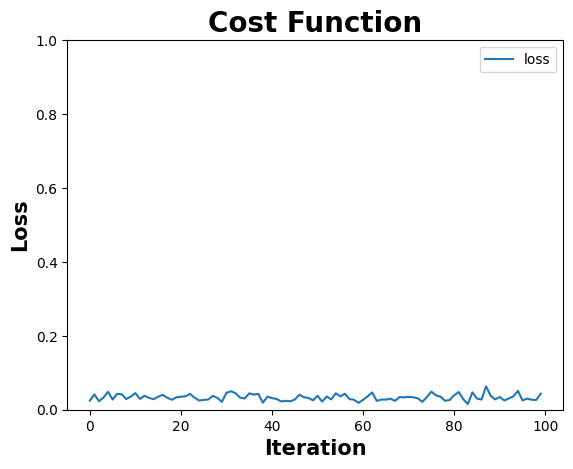

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
TN, FP, FN, TP: 36 0 0 21
Accuracy = 1.0
Precesion = 1.0
Recall = 1.0
F1 = 1.0
F0.5 = 1.0
F2 = 1.0
Gmean = 1.0
Balanced Accu. = 1.0
################################################## 9th CV ##################################################


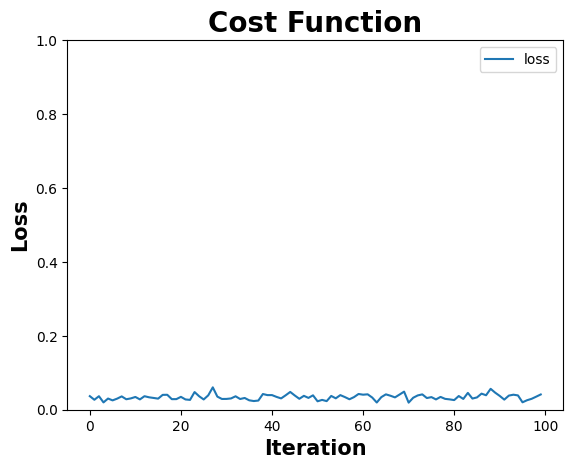

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
TN, FP, FN, TP: 35 1 0 21
Accuracy = 0.9824561403508771
Precesion = 0.9545454545454546
Recall = 1.0
F1 = 0.9767441860465116
F0.5 = 0.963302752293578
F2 = 0.9905660377358491
Gmean = 0.9860132971832694
Balanced Accu. = 0.9861111111111112
################################################## 10th CV ##################################################


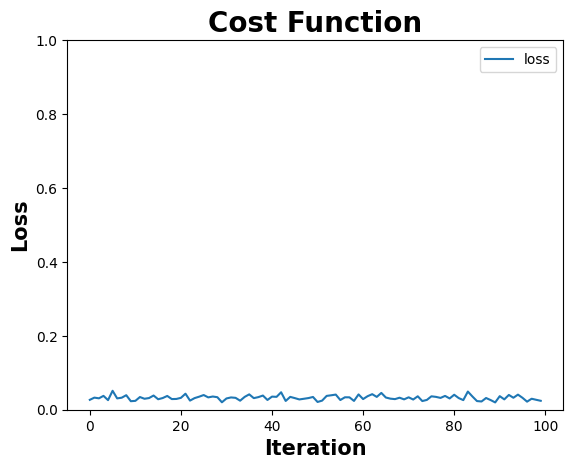

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
TN, FP, FN, TP: 35 0 0 21
Accuracy = 1.0
Precesion = 1.0
Recall = 1.0
F1 = 1.0
F0.5 = 1.0
F2 = 1.0
Gmean = 1.0
Balanced Accu. = 1.0


In [ ]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state = 2)

X = cancer_df.iloc[:, :-1]
y = cancer_df.iloc[:, -1]

L = 73
hidden_node = 2
# momentum=0.9
activation = 'sigmoid'
kernel_initializer=keras.initializers.he_normal(seed=100)
epochs=100

acc_acc = []
acc_f1 = []
acc_f5 = []
acc_f2 = []
acc_gmean = []
acc_bacc = []

n_iter=0

batch_size = int(X.shape[0]*0.9 * 0.05)
print('batch_size: ', batch_size)
learning_rate=0.001

model = Sequential()
model.add(Dense(hidden_node, input_dim=X.shape[1], kernel_initializer=kernel_initializer))
model.add(BatchNormalization())
model.add(Activation(activation))
model.add(Dense(1, activation='sigmoid'))
opt = optimizers.Adam(learning_rate = learning_rate)

for train_index, test_index in skf.split(cancer_df, cancer_df.iloc[:, -1]):
    n_iter += 1
    X_train = X.iloc[train_index]
    y_train= y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test= y.iloc[test_index]
    print('#'*50,'{0}th CV'.format(n_iter),'#'*50)
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    y_train = y_train.astype(float)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    y_test = y_test.astype(float)

    model.compile(loss=SOL(score = 'accuracy', distribution = 'cosine', mu = 0.5, delta = 0.1, mode = 'average'))
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, verbose=0, batch_size=batch_size)
    plt.plot(history.history['loss'], label='loss')
    plt.ylim([0, 1])
    plt.xlabel('Iteration',fontweight="bold",fontsize = 15)
    plt.ylabel('Loss',fontweight="bold",fontsize = 15)
    plt.title("Cost Function",fontweight="bold",fontsize = 20)
    plt.legend()
    plt.show()
    predicted = np.round(model.predict(X_test))
    TN = metrics.confusion_matrix(y_test, predicted)[0,0]
    FP = metrics.confusion_matrix(y_test, predicted)[0,1]
    FN = metrics.confusion_matrix(y_test, predicted)[1,0]
    TP = metrics.confusion_matrix(y_test, predicted)[1,1]
    print("TN, FP, FN, TP:", TN, FP, FN, TP)
    print('Accuracy =', (TP+TN)/(TP+TN+FP+FN))
    print('Precesion =', TP/(TP+FP))
    print('Recall =', TP/(TP+FN))
    print('F1 =', TP / (TP + 0.5*(FP+FN)))
    print('F0.5 =', TP / (TP + 0.8*FP + 0.2*FN))
    print('F2 =', TP / (TP + 0.2*FP + 0.8*FN))
    print('Gmean =', ((TP/(TP+FN)) * (TN/(TN+FP)))**0.5)
    print('Balanced Accu. =', 0.5*(TP/(TP+FN) + TN/(TN+FP)))
    acc_acc.append((TP+TN)/(TP+TN+FP+FN))
    acc_f1.append(TP / (TP + 0.5*(FP+FN)))
    acc_f5.append(TP / (TP + 0.8*FP + 0.2*FN))
    acc_f2.append(TP / (TP + 0.2*FP + 0.8*FN))
    acc_gmean.append(((TP/(TP+FN)) * (TN/(TN+FP)))**0.5)
    acc_bacc.append(0.5*(TP/(TP+FN) + TN/(TN+FP)))

In [ ]:
res['AccAim'] = [np.mean(acc_acc), np.mean(acc_f1), np.mean(acc_f5), np.mean(acc_f2), np.mean(acc_gmean), np.mean(acc_bacc)]
res

,Delta,BCE,AccAim,F1Aim,F.5Aim,F2Aim,GAim,BAim
Acc,0,0,0.977193,0,0,0,0,0
F1,0,0,0.968218,0,0,0,0,0
F.5,0,0,0.975518,0,0,0,0,0
F2,0,0,0.961618,0,0,0,0,0
Gmean,0,0,0.972623,0,0,0,0,0
B_Acc,0,0,0.973193,0,0,0,0,0


batch_size:  25
################################################## 1th CV ##################################################


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


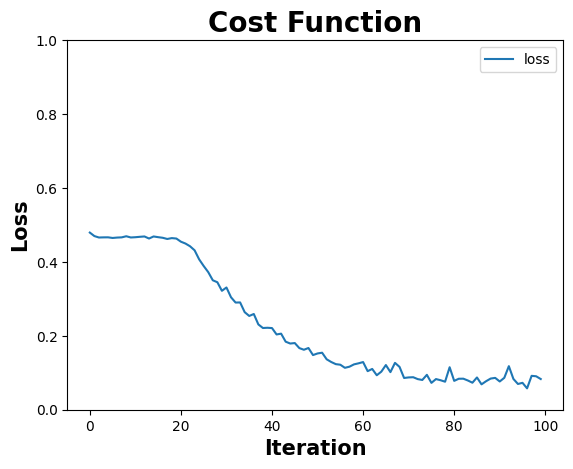

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
TN, FP, FN, TP: 35 0 2 20
Accuracy = 0.9649122807017544
Precesion = 1.0
Recall = 0.9090909090909091
F1 = 0.9523809523809523
F0.5 = 0.9803921568627452
F2 = 0.9259259259259258
Gmean = 0.9534625892455924
Balanced Accu. = 0.9545454545454546
################################################## 2th CV ##################################################


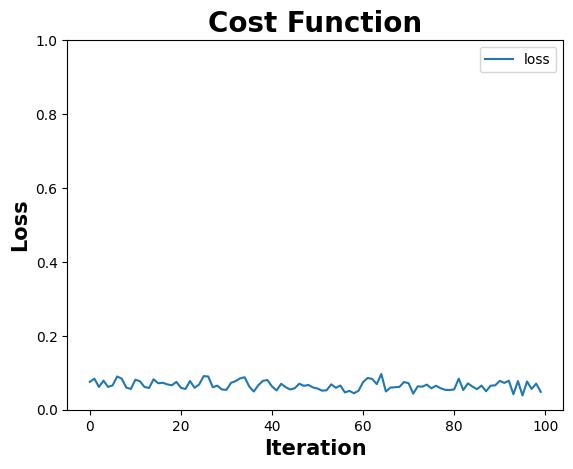

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
TN, FP, FN, TP: 35 0 1 21
Accuracy = 0.9824561403508771
Precesion = 1.0
Recall = 0.9545454545454546
F1 = 0.9767441860465116
F0.5 = 0.9905660377358491
F2 = 0.963302752293578
Gmean = 0.9770084209183945
Balanced Accu. = 0.9772727272727273
################################################## 3th CV ##################################################


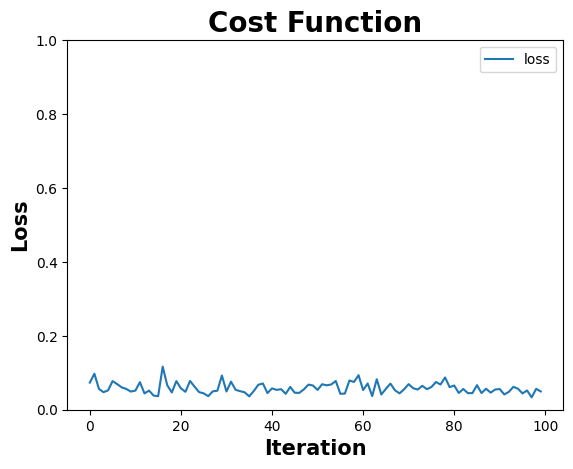

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
TN, FP, FN, TP: 36 0 2 19
Accuracy = 0.9649122807017544
Precesion = 1.0
Recall = 0.9047619047619048
F1 = 0.95
F0.5 = 0.9793814432989691
F2 = 0.9223300970873786
Gmean = 0.9511897312113419
Balanced Accu. = 0.9523809523809523
################################################## 4th CV ##################################################


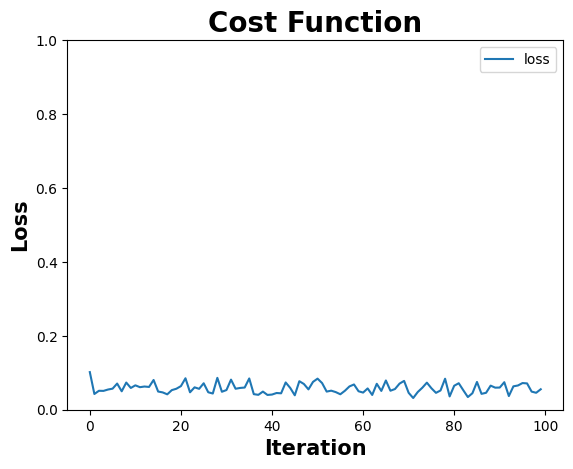

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
TN, FP, FN, TP: 36 0 1 20
Accuracy = 0.9824561403508771
Precesion = 1.0
Recall = 0.9523809523809523
F1 = 0.975609756097561
F0.5 = 0.9900990099009901
F2 = 0.9615384615384615
Gmean = 0.9759000729485332
Balanced Accu. = 0.9761904761904762
################################################## 5th CV ##################################################


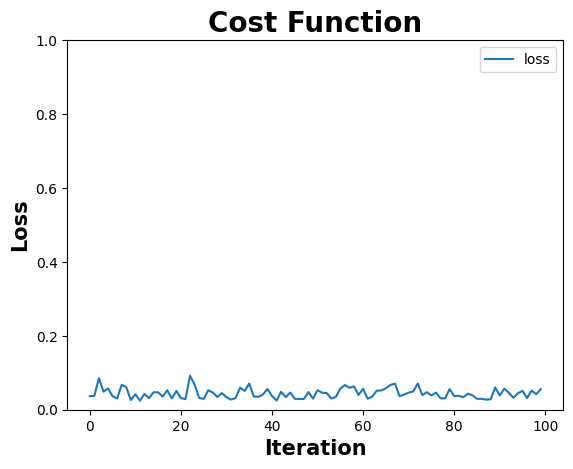

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
TN, FP, FN, TP: 35 1 4 17
Accuracy = 0.9122807017543859
Precesion = 0.9444444444444444
Recall = 0.8095238095238095
F1 = 0.8717948717948718
F0.5 = 0.9139784946236559
F2 = 0.8333333333333334
Gmean = 0.8871510790372952
Balanced Accu. = 0.8908730158730158
################################################## 6th CV ##################################################


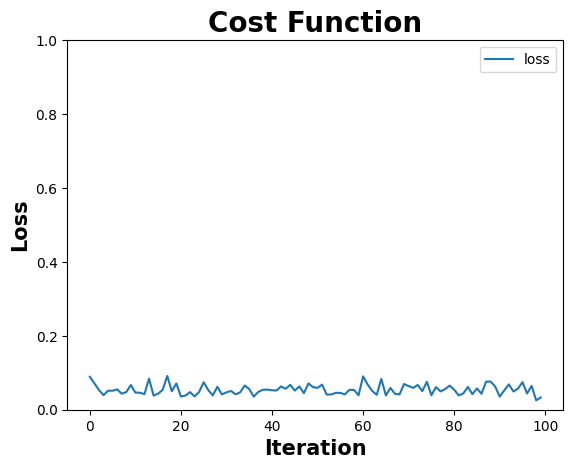

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
TN, FP, FN, TP: 36 0 0 21
Accuracy = 1.0
Precesion = 1.0
Recall = 1.0
F1 = 1.0
F0.5 = 1.0
F2 = 1.0
Gmean = 1.0
Balanced Accu. = 1.0
################################################## 7th CV ##################################################


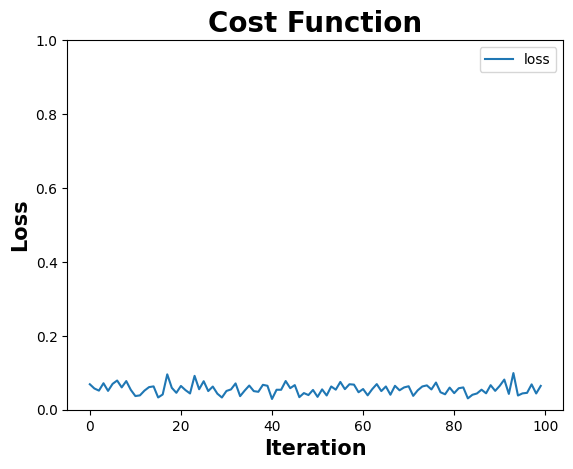

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
TN, FP, FN, TP: 36 0 0 21
Accuracy = 1.0
Precesion = 1.0
Recall = 1.0
F1 = 1.0
F0.5 = 1.0
F2 = 1.0
Gmean = 1.0
Balanced Accu. = 1.0
################################################## 8th CV ##################################################


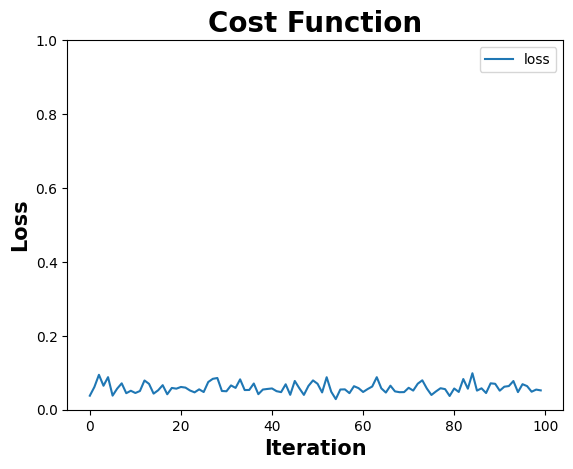

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
TN, FP, FN, TP: 36 0 0 21
Accuracy = 1.0
Precesion = 1.0
Recall = 1.0
F1 = 1.0
F0.5 = 1.0
F2 = 1.0
Gmean = 1.0
Balanced Accu. = 1.0
################################################## 9th CV ##################################################


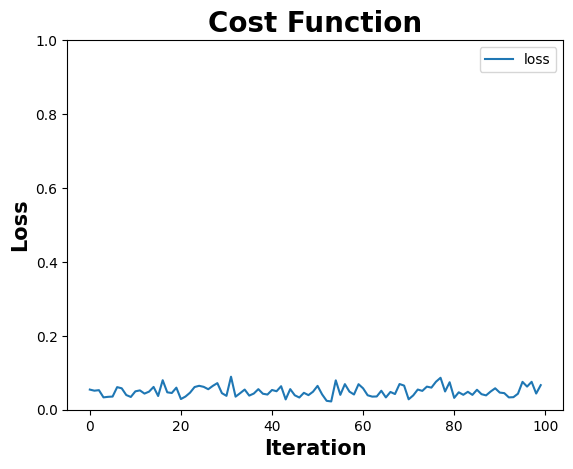

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
TN, FP, FN, TP: 35 1 0 21
Accuracy = 0.9824561403508771
Precesion = 0.9545454545454546
Recall = 1.0
F1 = 0.9767441860465116
F0.5 = 0.963302752293578
F2 = 0.9905660377358491
Gmean = 0.9860132971832694
Balanced Accu. = 0.9861111111111112
################################################## 10th CV ##################################################


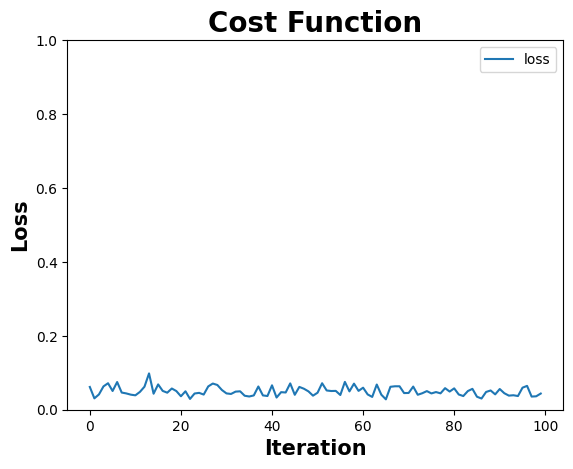

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
TN, FP, FN, TP: 35 0 0 21
Accuracy = 1.0
Precesion = 1.0
Recall = 1.0
F1 = 1.0
F0.5 = 1.0
F2 = 1.0
Gmean = 1.0
Balanced Accu. = 1.0


In [ ]:
f1_acc = []
f1_f1 = []
f1_f5 = []
f1_f2 = []
f1_gmean = []
f1_bacc = []

n_iter=0
batch_size = int(X.shape[0]*0.9 * 0.05)
print('batch_size: ', batch_size)
learning_rate=0.01

model = Sequential()
model.add(Dense(hidden_node, input_dim=X.shape[1], kernel_initializer=kernel_initializer))
model.add(BatchNormalization())
model.add(Activation(activation))
model.add(Dense(1, activation='sigmoid'))
opt = optimizers.Adam(learning_rate = learning_rate)

for train_index, test_index in skf.split(cancer_df, cancer_df.iloc[:, -1]):
    n_iter += 1
    X_train = X.iloc[train_index]
    y_train= y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test= y.iloc[test_index]
    print('#'*50,'{0}th CV'.format(n_iter),'#'*50)
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    y_train = y_train.astype(float)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    y_test = y_test.astype(float)

    model.compile(loss=SOL(score = 'f1_score', distribution = 'cosine', mu = 0.5, delta = 0.1, mode = 'average'))
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, verbose=0, batch_size=batch_size)
    plt.plot(history.history['loss'], label='loss')
    plt.ylim([0, 1])
    plt.xlabel('Iteration',fontweight="bold",fontsize = 15)
    plt.ylabel('Loss',fontweight="bold",fontsize = 15)
    plt.title("Cost Function",fontweight="bold",fontsize = 20)
    plt.legend()
    plt.show()
    predicted = np.round(model.predict(X_test))
    TN = metrics.confusion_matrix(y_test, predicted)[0,0]
    FP = metrics.confusion_matrix(y_test, predicted)[0,1]
    FN = metrics.confusion_matrix(y_test, predicted)[1,0]
    TP = metrics.confusion_matrix(y_test, predicted)[1,1]
    print("TN, FP, FN, TP:", TN, FP, FN, TP)
    print('Accuracy =', (TP+TN)/(TP+TN+FP+FN))
    print('Precesion =', TP/(TP+FP))
    print('Recall =', TP/(TP+FN))
    print('F1 =', TP / (TP + 0.5*(FP+FN)))
    print('F0.5 =', TP / (TP + 0.8*FP + 0.2*FN))
    print('F2 =', TP / (TP + 0.2*FP + 0.8*FN))
    print('Gmean =', ((TP/(TP+FN)) * (TN/(TN+FP)))**0.5)
    print('Balanced Accu. =', 0.5*(TP/(TP+FN) + TN/(TN+FP)))
    f1_acc.append((TP+TN)/(TP+TN+FP+FN))
    f1_f1.append(TP / (TP + 0.5*(FP+FN)))
    f1_f5.append(TP / (TP + 0.8*FP + 0.2*FN))
    f1_f2.append(TP / (TP + 0.2*FP + 0.8*FN))
    f1_gmean.append(((TP/(TP+FN)) * (TN/(TN+FP)))**0.5)
    f1_bacc.append(0.5*(TP/(TP+FN) + TN/(TN+FP)))

In [ ]:
res['F1Aim'] = [np.mean(f1_acc), np.mean(f1_f1), np.mean(f1_f5), np.mean(f1_f2), np.mean(f1_gmean), np.mean(f1_bacc)]
res

,Delta,BCE,AccAim,F1Aim,F.5Aim,F2Aim,GAim,BAim
Acc,0,0,0.977193,0.978947,0,0,0,0
F1,0,0,0.968218,0.970327,0,0,0,0
F.5,0,0,0.975518,0.981772,0,0,0,0
F2,0,0,0.961618,0.959700,0,0,0,0
Gmean,0,0,0.972623,0.973073,0,0,0,0
B_Acc,0,0,0.973193,0.973737,0,0,0,0


batch_size:  256
################################################## 1th CV ##################################################


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


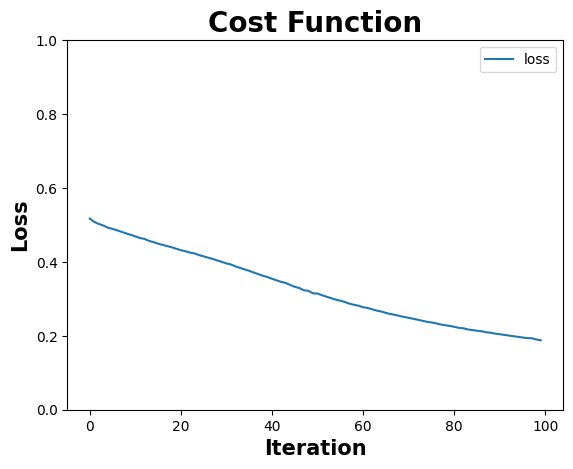

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
TN, FP, FN, TP: 34 1 2 20
Accuracy = 0.9473684210526315
Precesion = 0.9523809523809523
Recall = 0.9090909090909091
F1 = 0.9302325581395349
F0.5 = 0.9433962264150944
F2 = 0.9174311926605504
Gmean = 0.9397429877987296
Balanced Accu. = 0.9402597402597402
################################################## 2th CV ##################################################


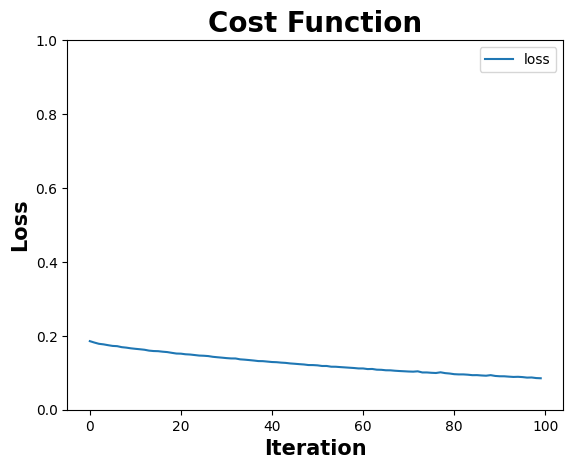

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
TN, FP, FN, TP: 34 1 1 21
Accuracy = 0.9649122807017544
Precesion = 0.9545454545454546
Recall = 0.9545454545454546
F1 = 0.9545454545454546
F0.5 = 0.9545454545454546
F2 = 0.9545454545454546
Gmean = 0.9629500128629352
Balanced Accu. = 0.9629870129870131
################################################## 3th CV ##################################################


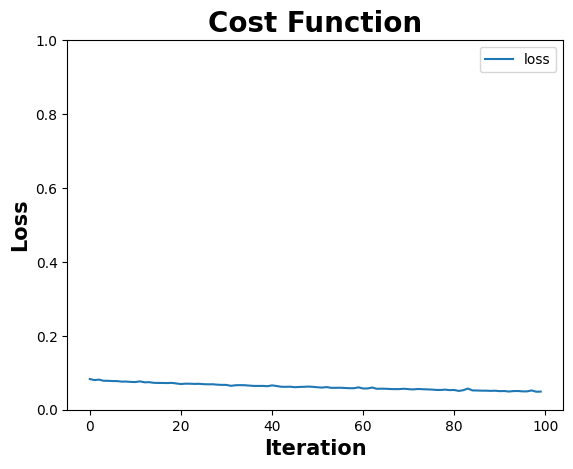

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
TN, FP, FN, TP: 36 0 1 20
Accuracy = 0.9824561403508771
Precesion = 1.0
Recall = 0.9523809523809523
F1 = 0.975609756097561
F0.5 = 0.9900990099009901
F2 = 0.9615384615384615
Gmean = 0.9759000729485332
Balanced Accu. = 0.9761904761904762
################################################## 4th CV ##################################################


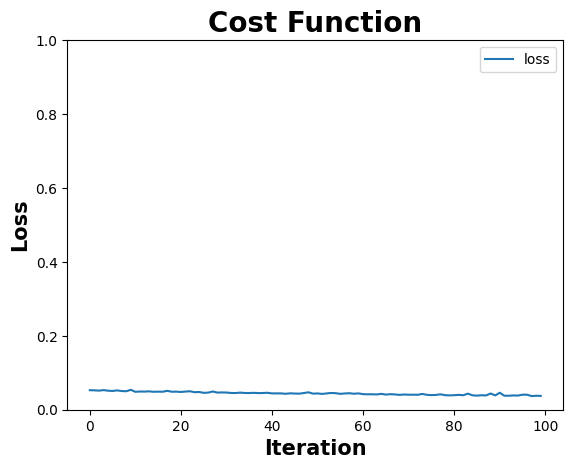

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
TN, FP, FN, TP: 36 0 1 20
Accuracy = 0.9824561403508771
Precesion = 1.0
Recall = 0.9523809523809523
F1 = 0.975609756097561
F0.5 = 0.9900990099009901
F2 = 0.9615384615384615
Gmean = 0.9759000729485332
Balanced Accu. = 0.9761904761904762
################################################## 5th CV ##################################################


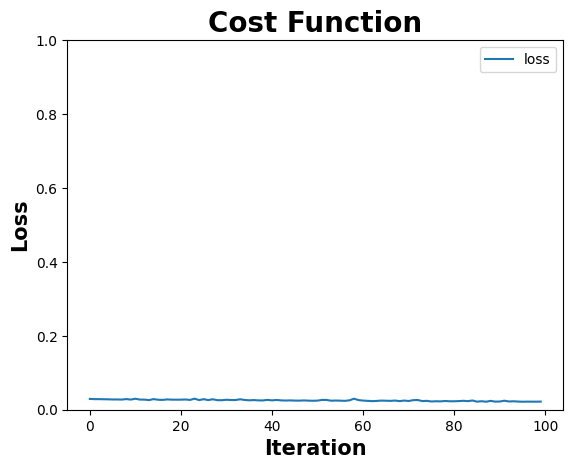

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
TN, FP, FN, TP: 35 1 3 18
Accuracy = 0.9298245614035088
Precesion = 0.9473684210526315
Recall = 0.8571428571428571
F1 = 0.9
F0.5 = 0.9278350515463917
F2 = 0.8737864077669902
Gmean = 0.9128709291752768
Balanced Accu. = 0.9146825396825397
################################################## 6th CV ##################################################


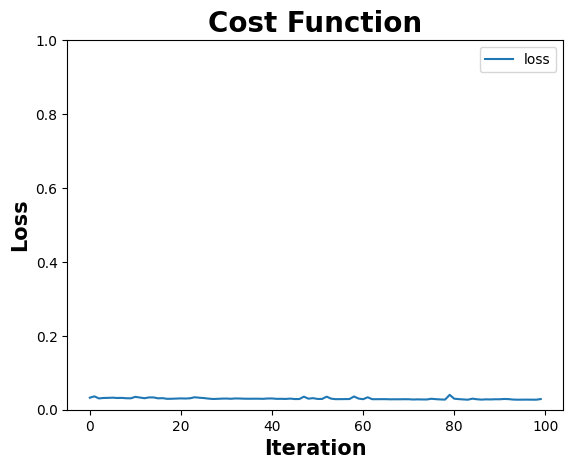

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
TN, FP, FN, TP: 35 1 0 21
Accuracy = 0.9824561403508771
Precesion = 0.9545454545454546
Recall = 1.0
F1 = 0.9767441860465116
F0.5 = 0.963302752293578
F2 = 0.9905660377358491
Gmean = 0.9860132971832694
Balanced Accu. = 0.9861111111111112
################################################## 7th CV ##################################################


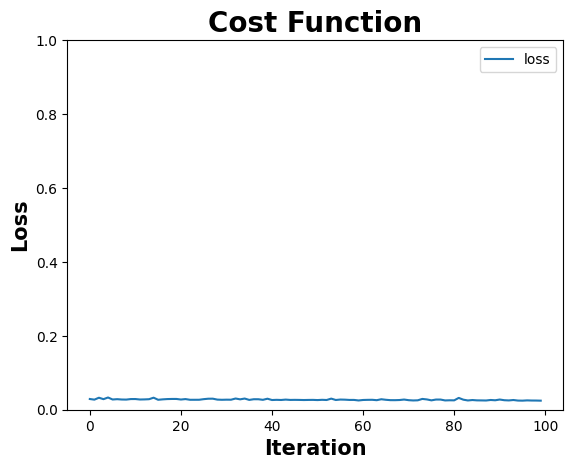

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
TN, FP, FN, TP: 36 0 0 21
Accuracy = 1.0
Precesion = 1.0
Recall = 1.0
F1 = 1.0
F0.5 = 1.0
F2 = 1.0
Gmean = 1.0
Balanced Accu. = 1.0
################################################## 8th CV ##################################################


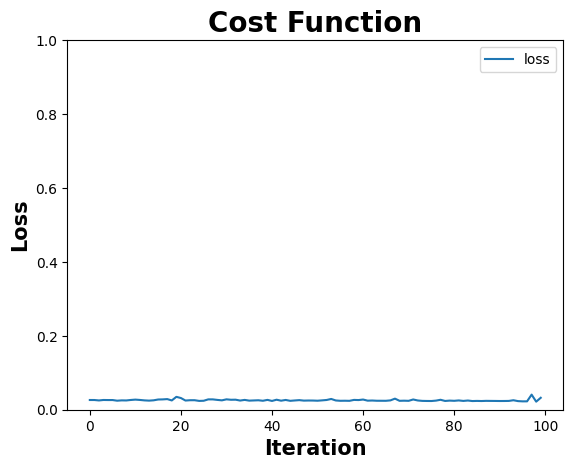

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
TN, FP, FN, TP: 36 0 0 21
Accuracy = 1.0
Precesion = 1.0
Recall = 1.0
F1 = 1.0
F0.5 = 1.0
F2 = 1.0
Gmean = 1.0
Balanced Accu. = 1.0
################################################## 9th CV ##################################################


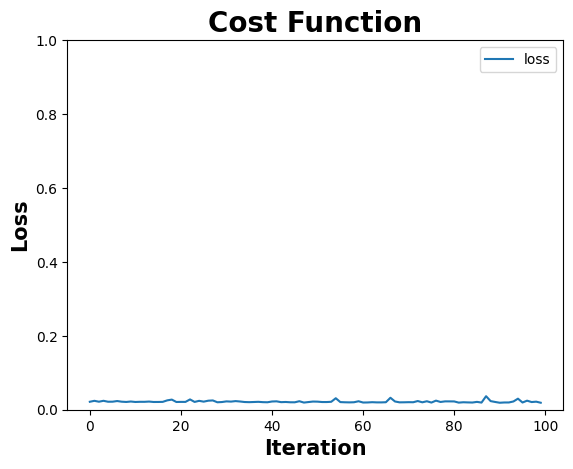

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
TN, FP, FN, TP: 35 1 0 21
Accuracy = 0.9824561403508771
Precesion = 0.9545454545454546
Recall = 1.0
F1 = 0.9767441860465116
F0.5 = 0.963302752293578
F2 = 0.9905660377358491
Gmean = 0.9860132971832694
Balanced Accu. = 0.9861111111111112
################################################## 10th CV ##################################################


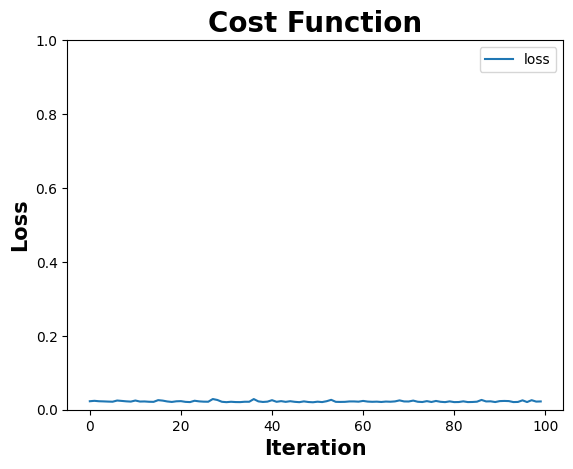

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
TN, FP, FN, TP: 35 0 0 21
Accuracy = 1.0
Precesion = 1.0
Recall = 1.0
F1 = 1.0
F0.5 = 1.0
F2 = 1.0
Gmean = 1.0
Balanced Accu. = 1.0


In [ ]:
bacc_acc = []
bacc_f1 = []
bacc_f5 = []
bacc_f2 = []
bacc_gmean = []
bacc_bacc = []

n_iter=0
batch_size = int(X.shape[0]*0.9 * 0.5)
print('batch_size: ', batch_size)
learning_rate=0.005

model = Sequential()
model.add(Dense(hidden_node, input_dim=X.shape[1], kernel_initializer=kernel_initializer))
model.add(BatchNormalization())
model.add(Activation(activation))
model.add(Dense(1, activation='sigmoid'))
opt = optimizers.Adam(learning_rate = learning_rate)

for train_index, test_index in skf.split(cancer_df, cancer_df.iloc[:, -1]):
    n_iter += 1
    X_train = X.iloc[train_index]
    y_train= y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test= y.iloc[test_index]
    print('#'*50,'{0}th CV'.format(n_iter),'#'*50)
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    y_train = y_train.astype(float)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    y_test = y_test.astype(float)

    model.compile(loss=SOL(score = 'bacc', distribution = 'cosine', mu = 0.5, delta = 0.1, mode = 'average'))
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, verbose=0, batch_size=batch_size)
    plt.plot(history.history['loss'], label='loss')
    plt.ylim([0, 1])
    plt.xlabel('Iteration',fontweight="bold",fontsize = 15)
    plt.ylabel('Loss',fontweight="bold",fontsize = 15)
    plt.title("Cost Function",fontweight="bold",fontsize = 20)
    plt.legend()
    plt.show()
    predicted = np.round(model.predict(X_test))
    TN = metrics.confusion_matrix(y_test, predicted)[0,0]
    FP = metrics.confusion_matrix(y_test, predicted)[0,1]
    FN = metrics.confusion_matrix(y_test, predicted)[1,0]
    TP = metrics.confusion_matrix(y_test, predicted)[1,1]
    print("TN, FP, FN, TP:", TN, FP, FN, TP)
    print('Accuracy =', (TP+TN)/(TP+TN+FP+FN))
    print('Precesion =', TP/(TP+FP))
    print('Recall =', TP/(TP+FN))
    print('F1 =', TP / (TP + 0.5*(FP+FN)))
    print('F0.5 =', TP / (TP + 0.8*FP + 0.2*FN))
    print('F2 =', TP / (TP + 0.2*FP + 0.8*FN))
    print('Gmean =', ((TP/(TP+FN)) * (TN/(TN+FP)))**0.5)
    print('Balanced Accu. =', 0.5*(TP/(TP+FN) + TN/(TN+FP)))
    bacc_acc.append((TP+TN)/(TP+TN+FP+FN))
    bacc_f1.append(TP / (TP + 0.5*(FP+FN)))
    bacc_f5.append(TP / (TP + 0.8*FP + 0.2*FN))
    bacc_f2.append(TP / (TP + 0.2*FP + 0.8*FN))
    bacc_gmean.append(((TP/(TP+FN)) * (TN/(TN+FP)))**0.5)
    bacc_bacc.append(0.5*(TP/(TP+FN) + TN/(TN+FP)))

In [ ]:
res['BAim'] = [np.mean(bacc_acc), np.mean(bacc_f1), np.mean(bacc_f5), np.mean(bacc_f2), np.mean(bacc_gmean), np.mean(bacc_bacc)]
res

,Delta,BCE,AccAim,F1Aim,F.5Aim,F2Aim,GAim,BAim
Acc,0,0,0.977193,0.978947,0,0,0,0.977193
F1,0,0,0.968218,0.970327,0,0,0,0.968949
F.5,0,0,0.975518,0.981772,0,0,0,0.973258
F2,0,0,0.961618,0.959700,0,0,0,0.964997
Gmean,0,0,0.972623,0.973073,0,0,0,0.973939
B_Acc,0,0,0.973193,0.973737,0,0,0,0.974253


# **4. DIABETES PREDICTION**

In [ ]:
diab_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Major-project-8th-sem/diabetes_prediction_dataset.csv')
diab_df.shape

(100000, 9)

In [ ]:
gen_encoded, gen_class = pd.factorize(diab_df['gender'])
print(gen_class)
gen_encoded

Index(['Female', 'Male', 'Other'], dtype='object')


array([0, 0, 1, ..., 1, 0, 0])

In [ ]:
pd.Series(gen_encoded).value_counts()


,count
0,58552
1,41430
2,18


In [ ]:
diab_df['gender'] = gen_encoded
diab_df

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,80.0,0,1,never,25.19,6.6,140,0
1,0,54.0,0,0,No Info,27.32,6.6,80,0
2,1,28.0,0,0,never,27.32,5.7,158,0
3,0,36.0,0,0,current,23.45,5.0,155,0
4,1,76.0,1,1,current,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
99995,0,80.0,0,0,No Info,27.32,6.2,90,0
99996,0,2.0,0,0,No Info,17.37,6.5,100,0
99997,1,66.0,0,0,former,27.83,5.7,155,0
99998,0,24.0,0,0,never,35.42,4.0,100,0


In [ ]:
smo_encoded, smo_class = pd.factorize(diab_df['smoking_history'])
print(smo_class)
smo_encoded

Index(['never', 'No Info', 'current', 'former', 'ever', 'not current'], dtype='object')


array([0, 1, 0, ..., 3, 0, 2])

In [ ]:
pd.Series(smo_encoded).value_counts()


,count
1,35816
0,35095
3,9352
2,9286
5,6447
4,4004


In [ ]:
diab_df['smoking_history'] = smo_encoded
diab_df

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,80.0,0,1,0,25.19,6.6,140,0
1,0,54.0,0,0,1,27.32,6.6,80,0
2,1,28.0,0,0,0,27.32,5.7,158,0
3,0,36.0,0,0,2,23.45,5.0,155,0
4,1,76.0,1,1,2,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
99995,0,80.0,0,0,1,27.32,6.2,90,0
99996,0,2.0,0,0,1,17.37,6.5,100,0
99997,1,66.0,0,0,3,27.83,5.7,155,0
99998,0,24.0,0,0,0,35.42,4.0,100,0


In [ ]:
diab_df.describe()


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.414660,41.885856,0.07485,0.039420,1.306950,27.320767,5.527507,138.058060,0.085000
std,0.493031,22.516840,0.26315,0.194593,1.454501,6.636783,1.070672,40.708136,0.278883
min,0.000000,0.080000,0.00000,0.000000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,0.000000,24.000000,0.00000,0.000000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,0.000000,43.000000,0.00000,0.000000,1.000000,27.320000,5.800000,140.000000,0.000000
75%,1.000000,60.000000,0.00000,0.000000,2.000000,29.580000,6.200000,159.000000,0.000000
max,2.000000,80.000000,1.00000,1.000000,5.000000,95.690000,9.000000,300.000000,1.000000


In [ ]:
diab_df.iloc[:,:-1] = (diab_df.iloc[:,:-1] - diab_df.iloc[:,:-1].mean())/diab_df.iloc[:,:-1].std()

diab_df

<ipython-input-41-98931c14219f>:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0       -0.841043
1       -0.841043
2        1.187228
3       -0.841043
4        1.187228
           ...   
99995   -0.841043
99996   -0.841043
99997    1.187228
99998   -0.841043
99999   -0.841043
Name: gender, Length: 100000, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  diab_df.iloc[:,:-1] = (diab_df.iloc[:,:-1] - diab_df.iloc[:,:-1].mean())/diab_df.iloc[:,:-1].std()
<ipython-input-41-98931c14219f>:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0       -0.284438
1       -0.284438
2       -0.284438
3       -0.284438
4        3.515669
           ...   
99995   -0.284438
99996   -0.284438
99997   -0.284438
99998   -0.284438
99999   -0.284438
Name: hypertension, Length: 100000, dtype: float64' has dtype in

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,-0.841043,1.692695,-0.284438,4.936354,-0.898556,-0.321054,1.001701,0.047704,0
1,-0.841043,0.538004,-0.284438,-0.202577,-0.211035,-0.000116,1.001701,-1.426203,0
2,1.187228,-0.616688,-0.284438,-0.202577,-0.898556,-0.000116,0.161107,0.489876,0
3,-0.841043,-0.261398,-0.284438,-0.202577,0.476486,-0.583229,-0.492688,0.416181,0
4,1.187228,1.515050,3.515669,4.936354,0.476486,-1.081965,-0.679486,0.416181,0
...,...,...,...,...,...,...,...,...,...
99995,-0.841043,1.692695,-0.284438,-0.202577,-0.211035,-0.000116,0.628104,-1.180552,0
99996,-0.841043,-1.771379,-0.284438,-0.202577,-0.211035,-1.499336,0.908301,-0.934901,0
99997,1.187228,1.070938,-0.284438,-0.202577,1.164008,0.076729,0.161107,0.416181,0
99998,-0.841043,-0.794332,-0.284438,-0.202577,-0.898556,1.220355,-1.426681,-0.934901,0


In [ ]:
res = pd.DataFrame({'Delta':[0, 0, 0, 0, 0, 0],
                    'BCE':[0, 0, 0, 0, 0, 0],
                    'AccAim':[0, 0, 0, 0, 0, 0],
                    'F1Aim':[0, 0, 0, 0, 0, 0],
                    'F.5Aim':[0, 0, 0, 0, 0, 0],
                    'F2Aim':[0, 0, 0, 0, 0, 0],
                    'GAim':[0, 0, 0, 0, 0, 0],
                    'BAim':[0, 0, 0, 0, 0, 0]}, index = ['Acc','F1','F.5','F2','Gmean','B_Acc'])

In [ ]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state = 2)

X = diab_df.iloc[:, :-1]
y = diab_df.iloc[:, -1]

L = 73
hidden_node = 2
activation = 'sigmoid'
kernel_initializer=keras.initializers.he_normal(seed=100)
epochs=100

batch_size:  4500
################################################## 1th CV ##################################################


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


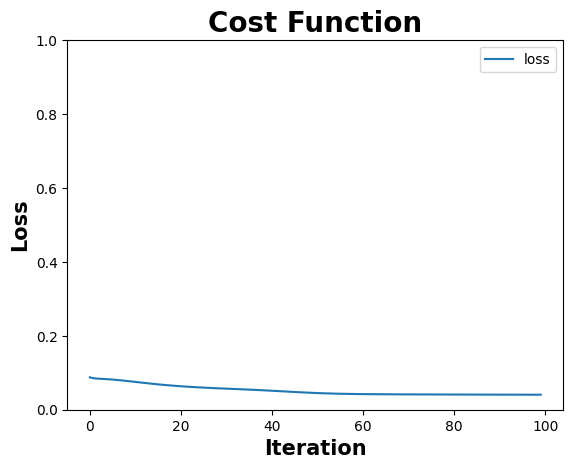

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
TN, FP, FN, TP: 9104 46 345 505
Accuracy = 0.9609
Precesion = 0.9165154264972777
Recall = 0.5941176470588235
F1 = 0.7209136331192005
F0.5 = 0.8267845448592012
F2 = 0.6390787142495571
Gmean = 0.76885032750265
Balanced Accu. = 0.7945451623272259
################################################## 2th CV ##################################################


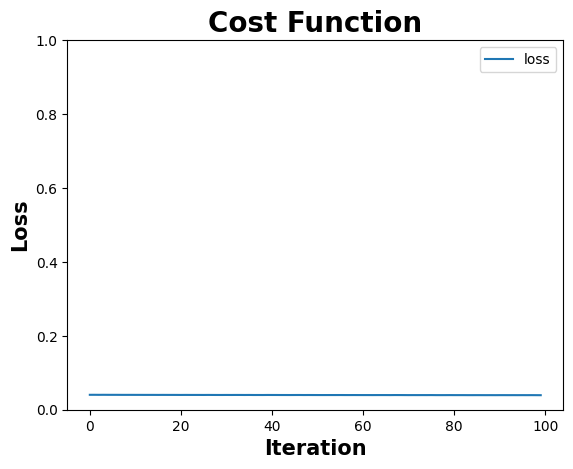

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
TN, FP, FN, TP: 9085 65 343 507
Accuracy = 0.9592
Precesion = 0.8863636363636364
Recall = 0.5964705882352941
F1 = 0.7130801687763713
F0.5 = 0.8078393881453154
F2 = 0.6382175226586102
Gmean = 0.7695669986929913
Balanced Accu. = 0.794683381549341
################################################## 3th CV ##################################################


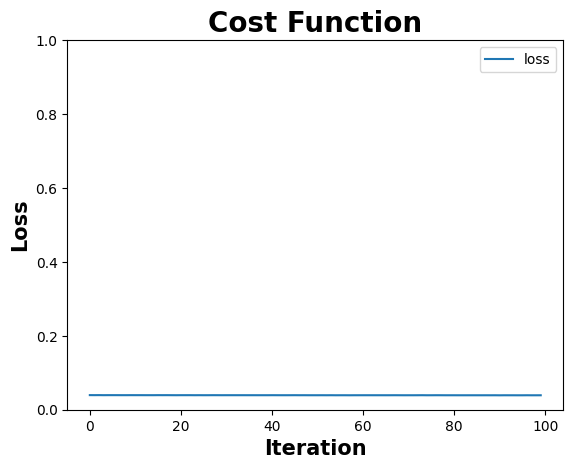

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
TN, FP, FN, TP: 9106 44 358 492
Accuracy = 0.9598
Precesion = 0.917910447761194
Recall = 0.5788235294117647
F1 = 0.70995670995671
F0.5 = 0.8216432865731462
F2 = 0.625
Gmean = 0.7589730665303075
Balanced Accu. = 0.787007393121183
################################################## 4th CV ##################################################


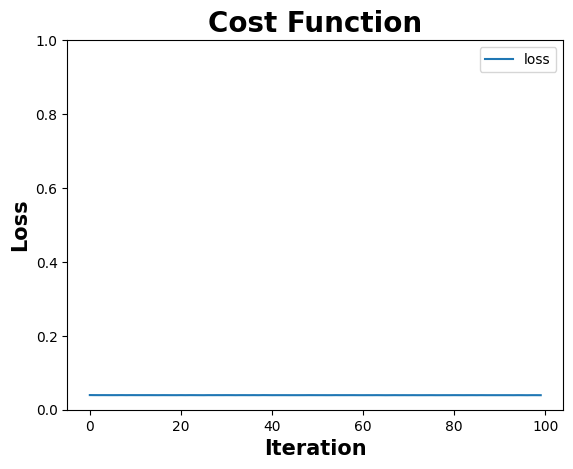

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
TN, FP, FN, TP: 9111 39 329 521
Accuracy = 0.9632
Precesion = 0.9303571428571429
Recall = 0.6129411764705882
F1 = 0.7390070921985815
F0.5 = 0.843042071197411
F2 = 0.6578282828282829
Gmean = 0.7812353296597527
Balanced Accu. = 0.8043394406943105
################################################## 5th CV ##################################################


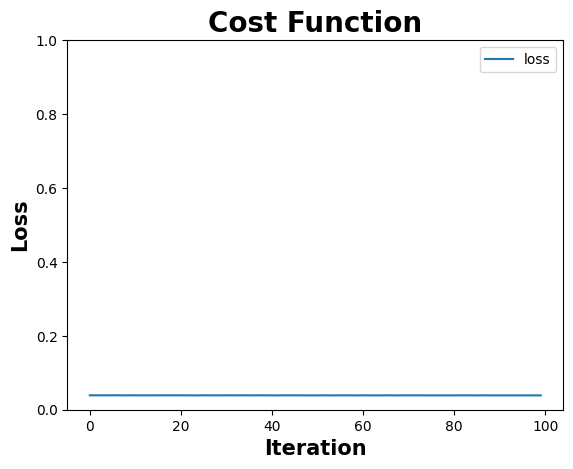

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
TN, FP, FN, TP: 9091 59 344 506
Accuracy = 0.9597
Precesion = 0.8955752212389381
Recall = 0.5952941176470589
F1 = 0.7151943462897526
F0.5 = 0.8135048231511254
F2 = 0.6380832282471627
Gmean = 0.7690615119279455
Balanced Accu. = 0.7944230151076824
################################################## 6th CV ##################################################


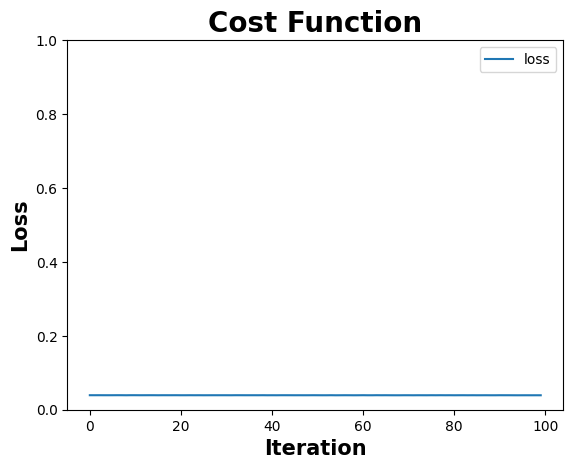

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
TN, FP, FN, TP: 9097 53 315 535
Accuracy = 0.9632
Precesion = 0.9098639455782312
Recall = 0.6294117647058823
F1 = 0.7440890125173852
F0.5 = 0.8354153653966271
F2 = 0.6707622868605817
Gmean = 0.7910537223492211
Balanced Accu. = 0.8118097074895532
################################################## 7th CV ##################################################


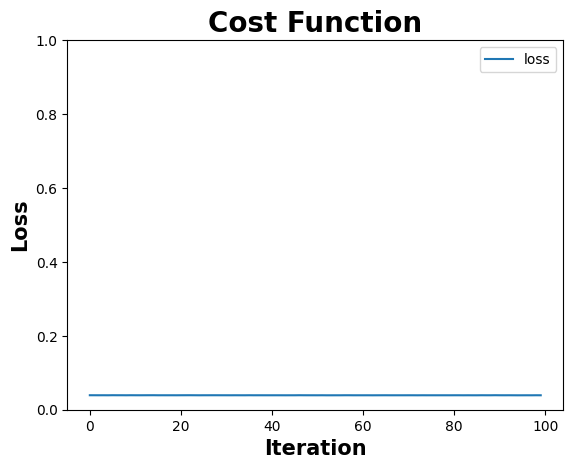

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
TN, FP, FN, TP: 9115 35 335 515
Accuracy = 0.963
Precesion = 0.9363636363636364
Recall = 0.6058823529411764
F1 = 0.7357142857142858
F0.5 = 0.8442622950819673
F2 = 0.6518987341772152
Gmean = 0.7768943108109128
Balanced Accu. = 0.8010286081645772
################################################## 8th CV ##################################################


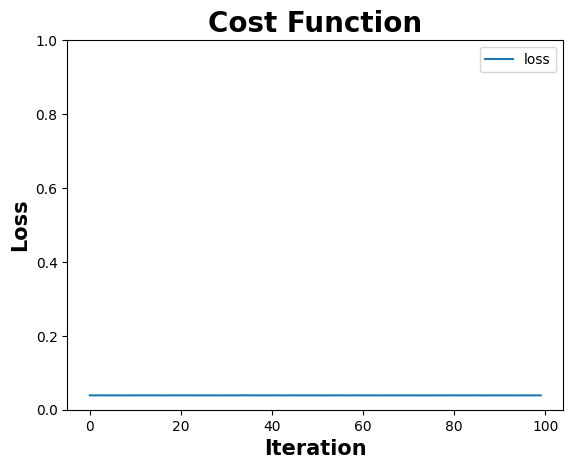

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
TN, FP, FN, TP: 9100 50 343 507
Accuracy = 0.9607
Precesion = 0.9102333931777379
Recall = 0.5964705882352941
F1 = 0.720682302771855
F0.5 = 0.8235867446393762
F2 = 0.6406368460955268
Gmean = 0.7702020423978306
Balanced Accu. = 0.7955030536804886
################################################## 9th CV ##################################################


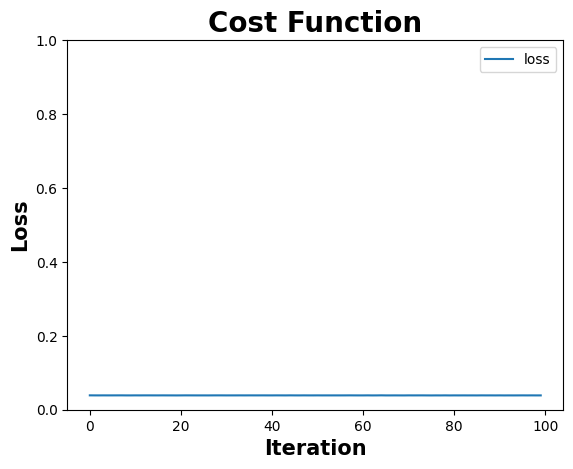

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
TN, FP, FN, TP: 9104 46 349 501
Accuracy = 0.9605
Precesion = 0.9159049360146252
Recall = 0.5894117647058823
F1 = 0.7172512526843235
F0.5 = 0.8245556287030943
F2 = 0.6346592348619204
Gmean = 0.7657993221045422
Balanced Accu. = 0.7921922211507554
################################################## 10th CV ##################################################


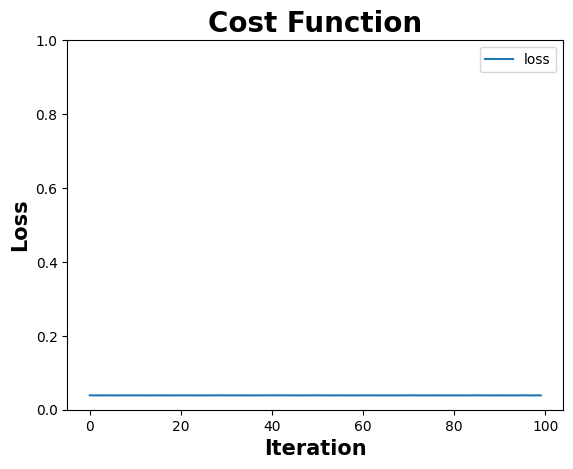

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
TN, FP, FN, TP: 9102 48 341 509
Accuracy = 0.9611
Precesion = 0.9138240574506283
Recall = 0.5988235294117648
F1 = 0.7235252309879175
F0.5 = 0.8268356075373618
F2 = 0.6431640131412686
Gmean = 0.7718044830636485
Balanced Accu. = 0.7967888138862103


In [ ]:
acc_acc = []
acc_f1 = []
acc_f5 = []
acc_f2 = []
acc_gmean = []
acc_bacc = []


n_iter=0
batch_size = int(X.shape[0]*0.9 * 0.05)
print('batch_size: ', batch_size)
learning_rate=0.01

model = Sequential()
model.add(Dense(hidden_node, input_dim=X.shape[1], kernel_initializer=kernel_initializer))
model.add(BatchNormalization())
model.add(Activation(activation))
model.add(Dense(1, activation='sigmoid'))
opt = optimizers.Adam(learning_rate = learning_rate)   # SGD(learning_rate=learning_rate, momentum=momentum)

for train_index, test_index in skf.split(diab_df, diab_df.iloc[:, -1]):
    n_iter += 1
    X_train = X.iloc[train_index]
    y_train= y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test= y.iloc[test_index]
    print('#'*50,'{0}th CV'.format(n_iter),'#'*50)
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    y_train = y_train.astype(float)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    y_test = y_test.astype(float)

    model.compile(loss=SOL(score = 'accuracy', distribution = 'cosine', mu = 0.5, delta = 0.1, mode = 'average'))
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, verbose=0, batch_size=batch_size)
    plt.plot(history.history['loss'], label='loss')
    plt.ylim([0, 1])
    plt.xlabel('Iteration',fontweight="bold",fontsize = 15)
    plt.ylabel('Loss',fontweight="bold",fontsize = 15)
    plt.title("Cost Function",fontweight="bold",fontsize = 20)
    plt.legend()
    plt.show()
    predicted = np.round(model.predict(X_test))
    TN = metrics.confusion_matrix(y_test, predicted)[0,0]
    FP = metrics.confusion_matrix(y_test, predicted)[0,1]
    FN = metrics.confusion_matrix(y_test, predicted)[1,0]
    TP = metrics.confusion_matrix(y_test, predicted)[1,1]
    print("TN, FP, FN, TP:", TN, FP, FN, TP)
    print('Accuracy =', (TP+TN)/(TP+TN+FP+FN))
    print('Precesion =', TP/(TP+FP))
    print('Recall =', TP/(TP+FN))
    print('F1 =', TP / (TP + 0.5*(FP+FN)))
    print('F0.5 =', TP / (TP + 0.8*FP + 0.2*FN))
    print('F2 =', TP / (TP + 0.2*FP + 0.8*FN))
    print('Gmean =', ((TP/(TP+FN)) * (TN/(TN+FP)))**0.5)
    print('Balanced Accu. =', 0.5*(TP/(TP+FN) + TN/(TN+FP)))
    acc_acc.append((TP+TN)/(TP+TN+FP+FN))
    acc_f1.append(TP / (TP + 0.5*(FP+FN)))
    acc_f5.append(TP / (TP + 0.8*FP + 0.2*FN))
    acc_f2.append(TP / (TP + 0.2*FP + 0.8*FN))
    acc_gmean.append(((TP/(TP+FN)) * (TN/(TN+FP)))**0.5)
    acc_bacc.append(0.5*(TP/(TP+FN) + TN/(TN+FP)))

In [ ]:
res['AccAim'] = [np.mean(acc_acc), np.mean(acc_f1), np.mean(acc_f5), np.mean(acc_f2), np.mean(acc_gmean), np.mean(acc_bacc)]
res

,Delta,BCE,AccAim,F1Aim,F.5Aim,F2Aim,GAim,BAim
Acc,0,0,0.961130,0,0,0,0,0
F1,0,0,0.723941,0,0,0,0,0
F.5,0,0,0.826747,0,0,0,0,0
F2,0,0,0.643933,0,0,0,0,0
Gmean,0,0,0.772344,0,0,0,0,0
B_Acc,0,0,0.797232,0,0,0,0,0


batch_size:  4500
################################################## 1th CV ##################################################


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


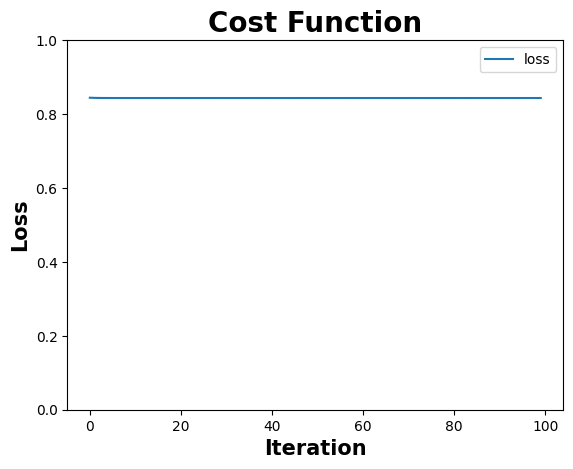

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
TN, FP, FN, TP: 0 9150 0 850
Accuracy = 0.085
Precesion = 0.085
Recall = 1.0
F1 = 0.15668202764976957
F0.5 = 0.10403916768665851
F2 = 0.31716417910447764
Gmean = 0.0
Balanced Accu. = 0.5
################################################## 2th CV ##################################################


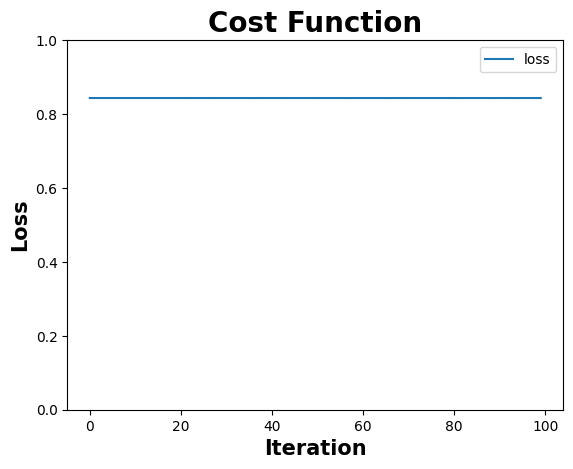

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
TN, FP, FN, TP: 0 9150 0 850
Accuracy = 0.085
Precesion = 0.085
Recall = 1.0
F1 = 0.15668202764976957
F0.5 = 0.10403916768665851
F2 = 0.31716417910447764
Gmean = 0.0
Balanced Accu. = 0.5
################################################## 3th CV ##################################################


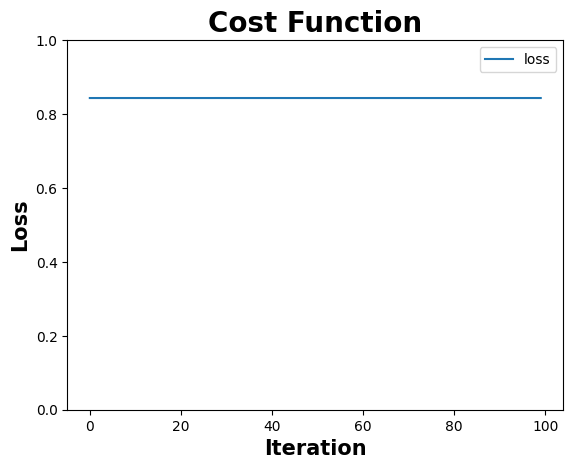

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
TN, FP, FN, TP: 0 9150 0 850
Accuracy = 0.085
Precesion = 0.085
Recall = 1.0
F1 = 0.15668202764976957
F0.5 = 0.10403916768665851
F2 = 0.31716417910447764
Gmean = 0.0
Balanced Accu. = 0.5
################################################## 4th CV ##################################################


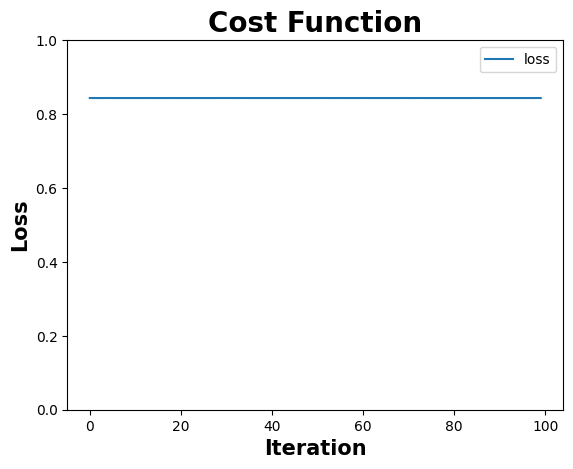

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
TN, FP, FN, TP: 0 9150 0 850
Accuracy = 0.085
Precesion = 0.085
Recall = 1.0
F1 = 0.15668202764976957
F0.5 = 0.10403916768665851
F2 = 0.31716417910447764
Gmean = 0.0
Balanced Accu. = 0.5
################################################## 5th CV ##################################################


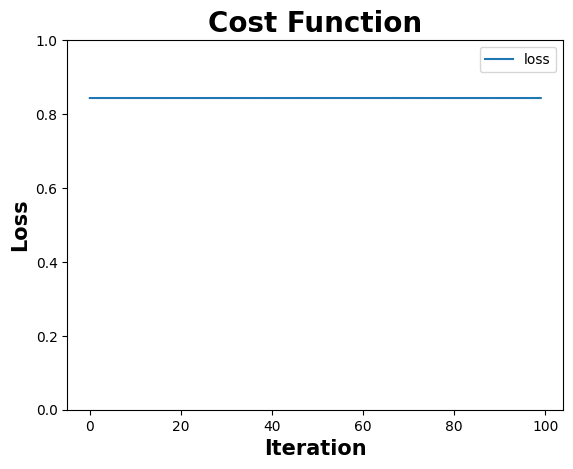

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
TN, FP, FN, TP: 0 9150 0 850
Accuracy = 0.085
Precesion = 0.085
Recall = 1.0
F1 = 0.15668202764976957
F0.5 = 0.10403916768665851
F2 = 0.31716417910447764
Gmean = 0.0
Balanced Accu. = 0.5
################################################## 6th CV ##################################################


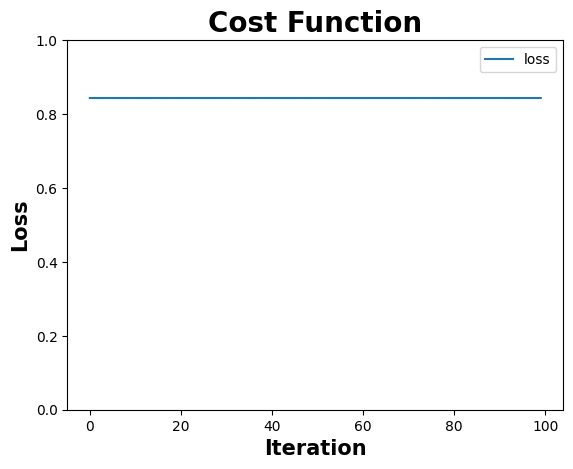

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
TN, FP, FN, TP: 0 9150 0 850
Accuracy = 0.085
Precesion = 0.085
Recall = 1.0
F1 = 0.15668202764976957
F0.5 = 0.10403916768665851
F2 = 0.31716417910447764
Gmean = 0.0
Balanced Accu. = 0.5
################################################## 7th CV ##################################################


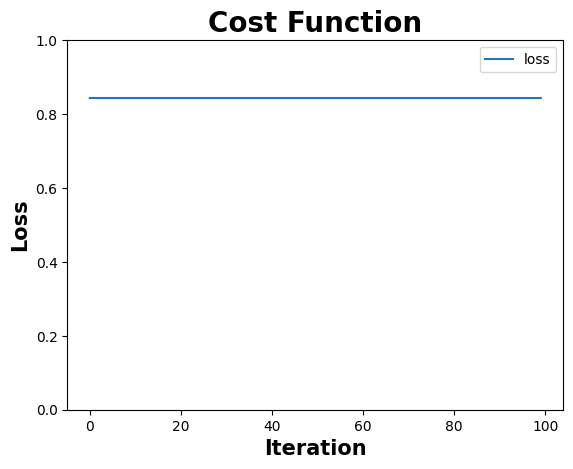

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
TN, FP, FN, TP: 0 9150 0 850
Accuracy = 0.085
Precesion = 0.085
Recall = 1.0
F1 = 0.15668202764976957
F0.5 = 0.10403916768665851
F2 = 0.31716417910447764
Gmean = 0.0
Balanced Accu. = 0.5
################################################## 8th CV ##################################################


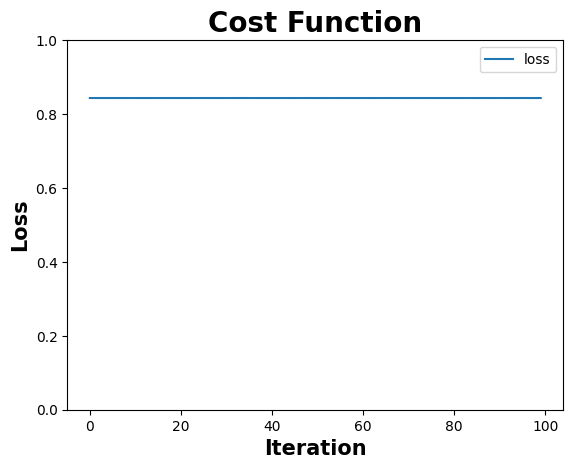

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
TN, FP, FN, TP: 0 9150 0 850
Accuracy = 0.085
Precesion = 0.085
Recall = 1.0
F1 = 0.15668202764976957
F0.5 = 0.10403916768665851
F2 = 0.31716417910447764
Gmean = 0.0
Balanced Accu. = 0.5
################################################## 9th CV ##################################################


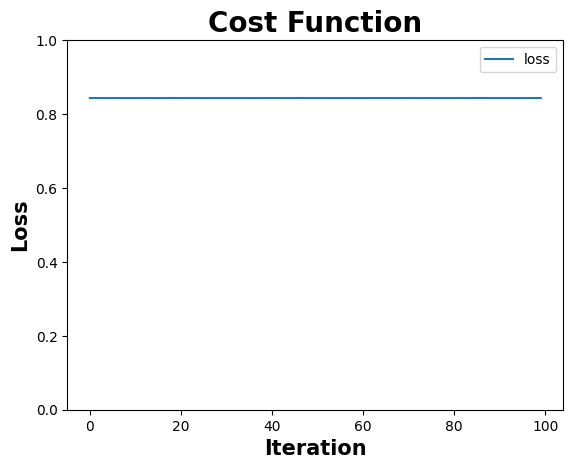

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
TN, FP, FN, TP: 0 9150 0 850
Accuracy = 0.085
Precesion = 0.085
Recall = 1.0
F1 = 0.15668202764976957
F0.5 = 0.10403916768665851
F2 = 0.31716417910447764
Gmean = 0.0
Balanced Accu. = 0.5
################################################## 10th CV ##################################################


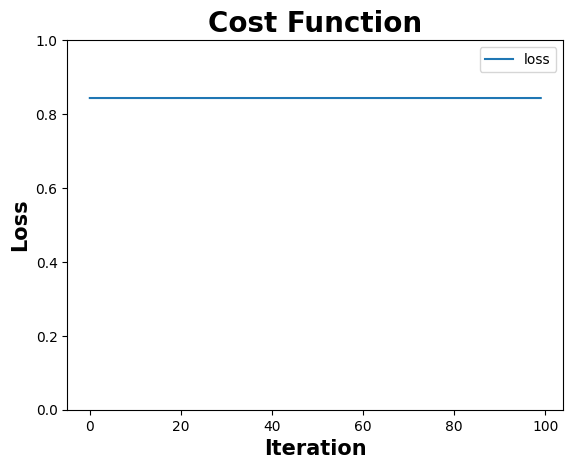

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
TN, FP, FN, TP: 0 9150 0 850
Accuracy = 0.085
Precesion = 0.085
Recall = 1.0
F1 = 0.15668202764976957
F0.5 = 0.10403916768665851
F2 = 0.31716417910447764
Gmean = 0.0
Balanced Accu. = 0.5


In [ ]:
f1_acc = []
f1_f1 = []
f1_f5 = []
f1_f2 = []
f1_gmean = []
f1_bacc = []

n_iter=0
batch_size = int(X.shape[0]*0.9 * 0.05)
print('batch_size: ', batch_size)
learning_rate=0.02

model = Sequential()
model.add(Dense(hidden_node, input_dim=X.shape[1], kernel_initializer=kernel_initializer))
model.add(BatchNormalization())
model.add(Activation(activation))
model.add(Dense(1, activation='sigmoid'))
opt = optimizers.Adam(learning_rate = learning_rate)

for train_index, test_index in skf.split(diab_df, diab_df.iloc[:, -1]):
    n_iter += 1
    X_train = X.iloc[train_index]
    y_train= y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test= y.iloc[test_index]
    print('#'*50,'{0}th CV'.format(n_iter),'#'*50)
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    y_train = y_train.astype(float)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    y_test = y_test.astype(float)

    model.compile(loss=SOL(score = 'f1_score', distribution = 'cosine', mu = 0.5, delta = 0.1, mode = 'average'))
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, verbose=0, batch_size=batch_size)
    plt.plot(history.history['loss'], label='loss')
    plt.ylim([0, 1])
    plt.xlabel('Iteration',fontweight="bold",fontsize = 15)
    plt.ylabel('Loss',fontweight="bold",fontsize = 15)
    plt.title("Cost Function",fontweight="bold",fontsize = 20)
    plt.legend()
    plt.show()
    predicted = np.round(model.predict(X_test))
    TN = metrics.confusion_matrix(y_test, predicted)[0,0]
    FP = metrics.confusion_matrix(y_test, predicted)[0,1]
    FN = metrics.confusion_matrix(y_test, predicted)[1,0]
    TP = metrics.confusion_matrix(y_test, predicted)[1,1]
    print("TN, FP, FN, TP:", TN, FP, FN, TP)
    print('Accuracy =', (TP+TN)/(TP+TN+FP+FN))
    print('Precesion =', TP/(TP+FP))
    print('Recall =', TP/(TP+FN))
    print('F1 =', TP / (TP + 0.5*(FP+FN)))
    print('F0.5 =', TP / (TP + 0.8*FP + 0.2*FN))
    print('F2 =', TP / (TP + 0.2*FP + 0.8*FN))
    print('Gmean =', ((TP/(TP+FN)) * (TN/(TN+FP)))**0.5)
    print('Balanced Accu. =', 0.5*(TP/(TP+FN) + TN/(TN+FP)))
    f1_acc.append((TP+TN)/(TP+TN+FP+FN))
    f1_f1.append(TP / (TP + 0.5*(FP+FN)))
    f1_f5.append(TP / (TP + 0.8*FP + 0.2*FN))
    f1_f2.append(TP / (TP + 0.2*FP + 0.8*FN))
    f1_gmean.append(((TP/(TP+FN)) * (TN/(TN+FP)))**0.5)
    f1_bacc.append(0.5*(TP/(TP+FN) + TN/(TN+FP)))

In [ ]:
res['F1Aim'] = [np.mean(f1_acc), np.mean(f1_f1), np.mean(f1_f5), np.mean(f1_f2), np.mean(f1_gmean), np.mean(f1_bacc)]
res

,Delta,BCE,AccAim,F1Aim,F.5Aim,F2Aim,GAim,BAim
Acc,0,0,0.961130,0.085000,0,0,0,0
F1,0,0,0.723941,0.156682,0,0,0,0
F.5,0,0,0.826747,0.104039,0,0,0,0
F2,0,0,0.643933,0.317164,0,0,0,0
Gmean,0,0,0.772344,0.000000,0,0,0,0
B_Acc,0,0,0.797232,0.500000,0,0,0,0


batch_size:  45000
################################################## 1th CV ##################################################


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


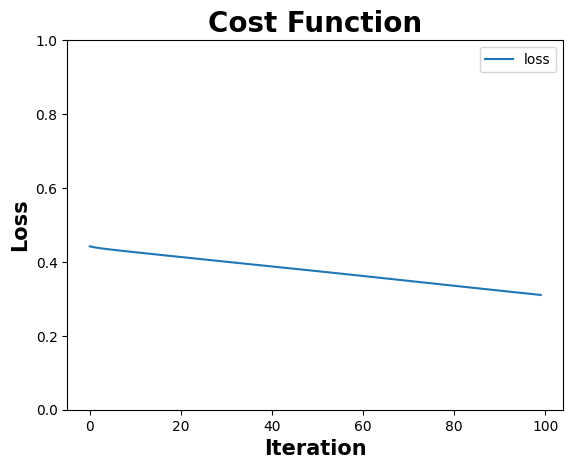

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
TN, FP, FN, TP: 6439 2711 112 738
Accuracy = 0.7177
Precesion = 0.2139750652363004
Recall = 0.8682352941176471
F1 = 0.3433356594556874
F0.5 = 0.2519459238017206
F2 = 0.5387647831800263
Gmean = 0.7816590915421823
Balanced Accu. = 0.7859755705560914
################################################## 2th CV ##################################################


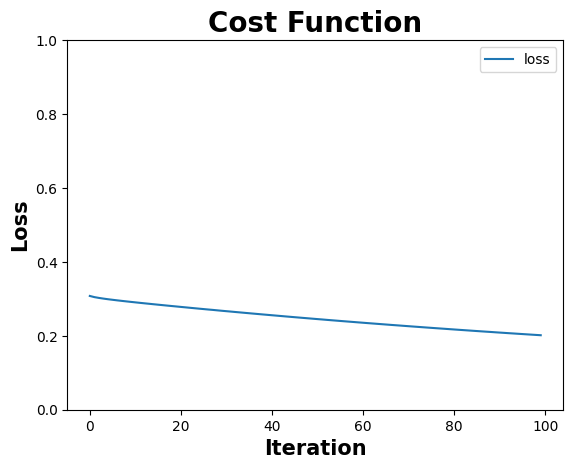

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
TN, FP, FN, TP: 7290 1860 93 757
Accuracy = 0.8047
Precesion = 0.28926251432938477
Recall = 0.8905882352941177
F1 = 0.4366887799250072
F0.5 = 0.33442304294044883
F2 = 0.6290510221040385
Gmean = 0.8423482811807123
Balanced Accu. = 0.8436547733847637
################################################## 3th CV ##################################################


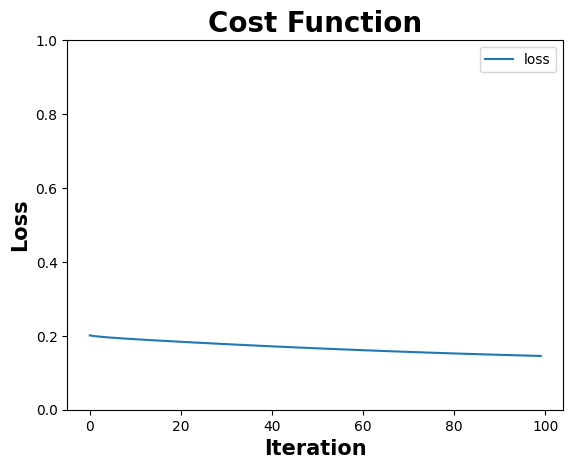

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
TN, FP, FN, TP: 7834 1316 80 770
Accuracy = 0.8604
Precesion = 0.3691275167785235
Recall = 0.9058823529411765
F1 = 0.5245231607629428
F0.5 = 0.41875135958233634
F2 = 0.7017863652934743
Gmean = 0.880677977341884
Balanced Accu. = 0.8810286081645773
################################################## 4th CV ##################################################


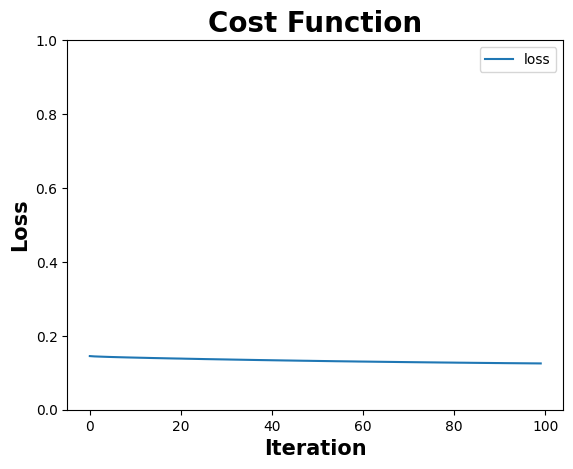

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
TN, FP, FN, TP: 7914 1236 78 772
Accuracy = 0.8686
Precesion = 0.3844621513944223
Recall = 0.908235294117647
F1 = 0.5402379286214136
F0.5 = 0.4345868047736996
F2 = 0.713757396449704
Gmean = 0.8863120691358397
Balanced Accu. = 0.8865766634522662
################################################## 5th CV ##################################################


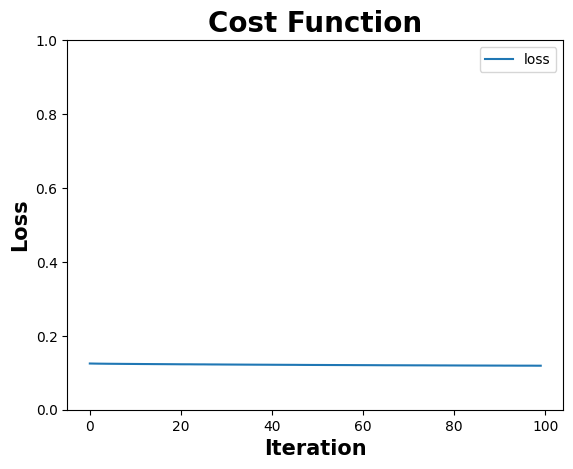

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
TN, FP, FN, TP: 7958 1192 78 772
Accuracy = 0.873
Precesion = 0.39307535641547864
Recall = 0.908235294117647
F1 = 0.5486851457000711
F0.5 = 0.4433723868596371
F2 = 0.7196122296793438
Gmean = 0.8887724985409081
Balanced Accu. = 0.8889810350369656
################################################## 6th CV ##################################################


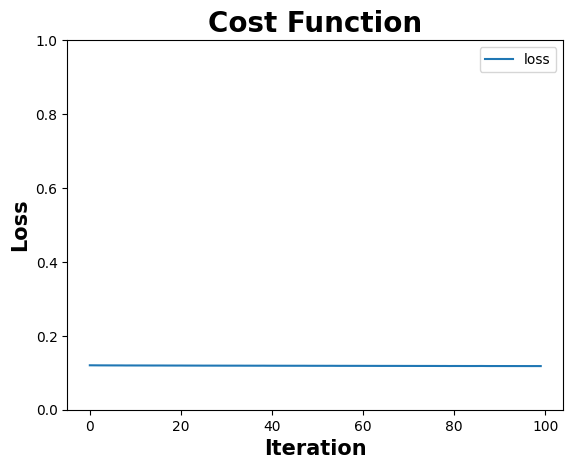

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
TN, FP, FN, TP: 8019 1131 75 775
Accuracy = 0.8794
Precesion = 0.40661070304302205
Recall = 0.9117647058823529
F1 = 0.5624092888243831
F0.5 = 0.45728109511446774
F2 = 0.7303053147380324
Gmean = 0.8939041388484212
Balanced Accu. = 0.8940790742526519
################################################## 7th CV ##################################################


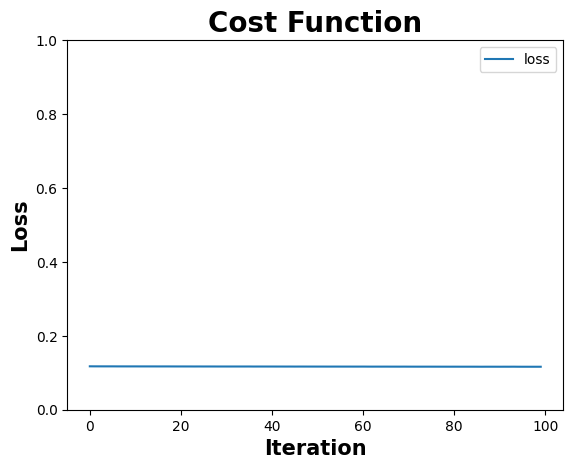

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
TN, FP, FN, TP: 7938 1212 75 775
Accuracy = 0.8713
Precesion = 0.39003522898842474
Recall = 0.9117647058823529
F1 = 0.5463517800493479
F0.5 = 0.4404410093203001
F2 = 0.7193242992389084
Gmean = 0.8893780128600661
Balanced Accu. = 0.8896528447444552
################################################## 8th CV ##################################################


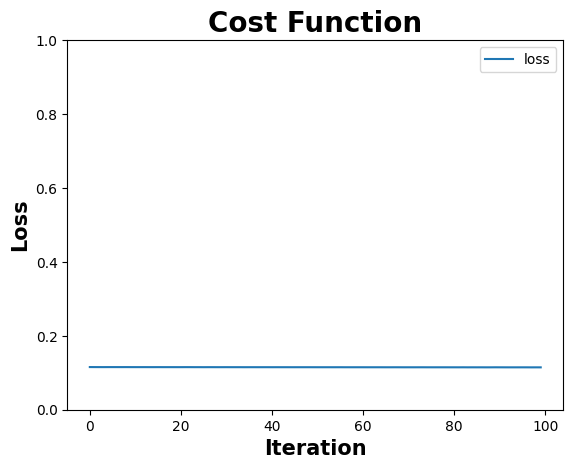

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
TN, FP, FN, TP: 7980 1170 93 757
Accuracy = 0.8737
Precesion = 0.3928386092371562
Recall = 0.8905882352941177
F1 = 0.5451926539431041
F0.5 = 0.44227623276466466
F2 = 0.7105312558663412
Gmean = 0.8813113749598143
Balanced Accu. = 0.8813596914175507
################################################## 9th CV ##################################################


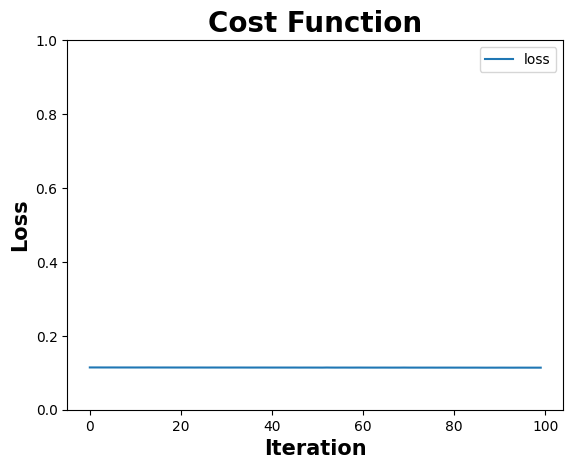

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
TN, FP, FN, TP: 7985 1165 101 749
Accuracy = 0.8734
Precesion = 0.39132706374085685
Recall = 0.8811764705882353
F1 = 0.5419681620839363
F0.5 = 0.44027745121090994
F2 = 0.7047421904403463
Gmean = 0.8769167370265402
Balanced Accu. = 0.8769270331083253
################################################## 10th CV ##################################################


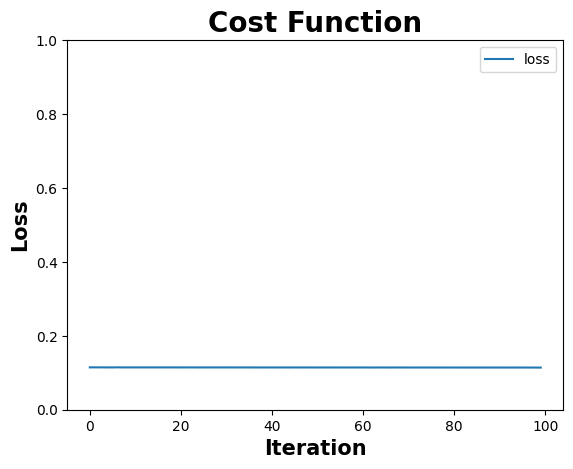

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
TN, FP, FN, TP: 7943 1207 80 770
Accuracy = 0.8713
Precesion = 0.3894790085988872
Recall = 0.9058823529411765
F1 = 0.5447470817120622
F0.5 = 0.4395980817538251
F2 = 0.7160126464571321
Gmean = 0.8867835616324954
Balanced Accu. = 0.8869848923175827


In [ ]:
bacc_acc = []
bacc_f1 = []
bacc_f5 = []
bacc_f2 = []
bacc_gmean = []
bacc_bacc = []


n_iter=0
batch_size = int(X.shape[0]*0.9 * 0.5)
print('batch_size: ', batch_size)
learning_rate=0.03

model = Sequential()
model.add(Dense(hidden_node, input_dim=X.shape[1], kernel_initializer=kernel_initializer))
model.add(BatchNormalization())
model.add(Activation(activation))
model.add(Dense(1, activation='sigmoid'))
opt = optimizers.Adam(learning_rate = learning_rate)
for train_index, test_index in skf.split(diab_df, diab_df.iloc[:, -1]):
    n_iter += 1
    X_train = X.iloc[train_index]
    y_train= y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test= y.iloc[test_index]
    print('#'*50,'{0}th CV'.format(n_iter),'#'*50)
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    y_train = y_train.astype(float)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    y_test = y_test.astype(float)

    model.compile(loss=SOL(score = 'bacc', distribution = 'cosine', mu = 0.5, delta = 0.1, mode = 'average'))
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, verbose=0, batch_size=batch_size)
    plt.plot(history.history['loss'], label='loss')
    plt.ylim([0, 1])
    plt.xlabel('Iteration',fontweight="bold",fontsize = 15)
    plt.ylabel('Loss',fontweight="bold",fontsize = 15)
    plt.title("Cost Function",fontweight="bold",fontsize = 20)
    plt.legend()
    plt.show()
    predicted = np.round(model.predict(X_test))
    TN = metrics.confusion_matrix(y_test, predicted)[0,0]
    FP = metrics.confusion_matrix(y_test, predicted)[0,1]
    FN = metrics.confusion_matrix(y_test, predicted)[1,0]
    TP = metrics.confusion_matrix(y_test, predicted)[1,1]
    print("TN, FP, FN, TP:", TN, FP, FN, TP)
    print('Accuracy =', (TP+TN)/(TP+TN+FP+FN))
    print('Precesion =', TP/(TP+FP))
    print('Recall =', TP/(TP+FN))
    print('F1 =', TP / (TP + 0.5*(FP+FN)))
    print('F0.5 =', TP / (TP + 0.8*FP + 0.2*FN))
    print('F2 =', TP / (TP + 0.2*FP + 0.8*FN))
    print('Gmean =', ((TP/(TP+FN)) * (TN/(TN+FP)))**0.5)
    print('Balanced Accu. =', 0.5*(TP/(TP+FN) + TN/(TN+FP)))
    bacc_acc.append((TP+TN)/(TP+TN+FP+FN))
    bacc_f1.append(TP / (TP + 0.5*(FP+FN)))
    bacc_f5.append(TP / (TP + 0.8*FP + 0.2*FN))
    bacc_f2.append(TP / (TP + 0.2*FP + 0.8*FN))
    bacc_gmean.append(((TP/(TP+FN)) * (TN/(TN+FP)))**0.5)
    bacc_bacc.append(0.5*(TP/(TP+FN) + TN/(TN+FP)))

In [ ]:
res['BAim'] = [np.mean(bacc_acc), np.mean(bacc_f1), np.mean(bacc_f5), np.mean(bacc_f2), np.mean(bacc_gmean), np.mean(bacc_bacc)]
res

,Delta,BCE,AccAim,F1Aim,F.5Aim,F2Aim,GAim,BAim
Acc,0,0,0.961130,0.085000,0,0,0,0.849350
F1,0,0,0.723941,0.156682,0,0,0,0.513414
F.5,0,0,0.826747,0.104039,0,0,0,0.410295
F2,0,0,0.643933,0.317164,0,0,0,0.688389
Gmean,0,0,0.772344,0.000000,0,0,0,0.870806
B_Acc,0,0,0.797232,0.500000,0,0,0,0.871522
